In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from sklearn.linear_model import LogisticRegression
from scipy.spatial.distance import mahalanobis
from tqdm import tqdm
from mks_test import mkstest
from scipy.stats import chi2, ks_2samp
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore')

In [2]:
data = pd.read_stata('data_Deming_2008_0217.dta')
data[data < 0] = np.nan # replace negative values with NaN
data_copy = data.copy()
data

,ChildID,AFQT_Pct81,AFQT_Pct81_REV,AgePreg94,AgePreg96,AgePreg98,Age_1stHS88,Age_1stHS90,Age_1stHS92,Age_1stHS94,...,YA_LD104,YA_LastInterview,YA_NumKids,YA_Res94,YA_Res96,YA_Res98,YA_Res100,YA_Res102,YA_Res104,hhID
0,201.0,12.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
1,202.0,12.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
2,301.0,51.0,46.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,2002.0,0.0,NaN,11.0,19.0,NaN,19.0,NaN,3.0
3,302.0,51.0,46.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,2002.0,0.0,NaN,NaN,19.0,11.0,11.0,NaN,3.0
4,303.0,51.0,46.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,2002.0,0.0,NaN,NaN,NaN,NaN,19.0,NaN,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11465,1267201.0,64.0,63.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12672.0
11466,1267202.0,64.0,63.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12672.0
11467,1267301.0,80.0,80.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12673.0
11468,1267302.0,80.0,80.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12673.0


In [3]:
def preprocess(data, elig_type=2):
    assert elig_type in [1, 2]
    # Eligibility

    # age
    survey_years = list(range(86, 106, 2))
    for year in survey_years:
        data[f'cleaned_age_mo_{year}'] = data[f'Age_Mo{year}']
        data[f'cleaned_age_mo_{year}'].fillna(data[f'PPVTAge{year}'], inplace=True)
    for idx, year in enumerate(survey_years):
        if idx != 0:
            mask = data[f'cleaned_age_mo_{year}'].isna() & data[f'cleaned_age_mo_{year-2}'].notna()
            data.loc[mask, f'cleaned_age_mo_{year}'] = data.loc[mask, f'cleaned_age_mo_{year-2}'] + 24
        if idx != len(survey_years) - 1:
            mask = data[f'cleaned_age_mo_{year}'].isna() & data[f'cleaned_age_mo_{year+2}'].notna() & data[f'cleaned_age_mo_{year+2}'] >= 25
            data.loc[mask, f'cleaned_age_mo_{year}'] = data.loc[mask, f'cleaned_age_mo_{year+2}'] - 24
    for year in survey_years:
        data[f'cleaned_age_yr_{year}'] = data[f'cleaned_age_mo_{year}'] // 12
        data[f'uncleaned_age_yr_{year}'] = data[f'Age_Mo{year}'] // 12


    # each household must have at least two eligible children
    grouped_data = data.groupby('MotherID')
    for year in [90]:
        age_month = f'Age_Mo{year}' if elig_type==1 else f'cleaned_age_mo_{year}'
        data[f'num_eligible_children_{year}'] = grouped_data[age_month].transform(lambda x: x[(x >= 54) & (x.notna())].count()) # 4 yr 6 months
        eligibility_mask = (data[f'num_eligible_children_{year}'] > 1) & (data[f'num_eligible_children_{year}'].notna())
        data.loc[eligibility_mask, f'eligibility_{year}'] = 1
        data.loc[~eligibility_mask, f'eligibility_{year}'] = 0

        death_mask = data[f'Res{year}'] == 8
        data.loc[death_mask, f'eligibility_{year}'] = np.nan
    data['deceased'] = data['Res104'] == 8

    # program participation
    headstart_participation_mask = (data['Ever_HS90'] == 1) | (data['Ever_HS88'] == 1)
    preschool_participation_mask = (data['Ever_Preschool90'] == 1) | (data['Ever_Preschool88'] == 1)
    eligibility_mask = data['eligibility_90'] == 1
    data['headstart_participation_90'] = headstart_participation_mask.apply(lambda x: x if np.isnan(x) else int(x))
    data.loc[~eligibility_mask, 'headstart_participation_90'] = np.nan
    data['preschool_participation_90'] = (preschool_participation_mask & ~headstart_participation_mask).apply(lambda x: x if np.isnan(x) else int(x))
    data.loc[~eligibility_mask, 'preschool_participation_90'] = np.nan
    data['no_preschool_participation_90'] = (~preschool_participation_mask & ~headstart_participation_mask).apply(lambda x: x if np.isnan(x) else int(x))
    data.loc[~eligibility_mask, 'no_preschool_participation_90'] = np.nan

    # within family treatment difference
    grouped_data = data.groupby('MotherID')
    year = 90

    hs_indicator = grouped_data[f'headstart_participation_{year}'].transform(lambda x: 1 if x.sum() > 0 else 0)
    pr_indicator = grouped_data[f'preschool_participation_{year}'].transform(lambda x: 1 if x.sum() > 0 else 0)
    no_indicator = grouped_data[f'no_preschool_participation_{year}'].transform(lambda x: 1 if x.sum() > 0 else 0)

    data[f'eligibility_siblingdifferenttreatment_{year}'] = ((hs_indicator + pr_indicator + no_indicator) >= 2) & (data[f'eligibility_{year}'] == 1)
    data[f'headstart_fixedeffect_indicator_{year}'] = data[f'headstart_participation_{year}']
    data[f'preschool_fixedeffect_indicator_{year}'] = data[f'preschool_participation_{year}']
    data[f'no_preschool_fixedeffect_indicator_{year}'] = data[f'no_preschool_participation_{year}']
    data.loc[~data[f'eligibility_siblingdifferenttreatment_{year}'], f'headstart_fixedeffect_indicator_{year}'] = np.nan
    data.loc[~data[f'eligibility_siblingdifferenttreatment_{year}'], f'preschool_fixedeffect_indicator_{year}'] = np.nan
    data.loc[~data[f'eligibility_siblingdifferenttreatment_{year}'], f'no_preschool_fixedeffect_indicator_{year}'] = np.nan
    data[f'eligibility_siblingdifferenttreatment_{year}'] = data[f'eligibility_siblingdifferenttreatment_{year}'].apply(lambda x: x if np.isnan(x) else int(x))


    data[f"program_participation_type_{year}"] = data[f'headstart_participation_{year}'] + 2 * data[f'preschool_participation_{year}'] + 3 * data[f'no_preschool_participation_{year}']
    data.loc[data[f'eligibility_{year}'] == 0, f"program_participation_type_{year}"] = np.nan

    data[f"program_participation_fixedeffect_type_{year}"] = data[f'headstart_fixedeffect_indicator_{year}'] + 2 * data[f'preschool_fixedeffect_indicator_{year}'] + 3 * data[f'no_preschool_fixedeffect_indicator_{year}']
    data.loc[data[f'eligibility_siblingdifferenttreatment_{year}'] == 0, f"program_participation_fixedeffect_type_{year}"] = np.nan



    # Covariates

    # race
    data['Hispanic'] = (data['Race_Child'] == 1).apply(lambda x: x if np.isnan(x) else int(x))
    data['Black'] = (data['Race_Child'] == 2).apply(lambda x: x if np.isnan(x) else int(x))
    data['White'] = (data['Race_Child'] == 3).apply(lambda x: x if np.isnan(x) else int(x))
    data['NonBlack'] = ((data['Race_Child'] != 2) & (data['Race_Child'].notna())).apply(lambda x: x if np.isnan(x) else int(x))

    # family income, adjust to 2004 dollars
    data['NetFamInc78'] *= 2.82
    data['NetFamInc79'] *= 2.54
    data['NetFamInc80'] *= 2.24
    data['NetFamInc81'] *= 2.03
    data['NetFamInc82'] *= 1.90
    data['NetFamInc83'] *= 1.85
    data['NetFamInc84'] *= 1.78
    data['NetFamInc85'] *= 1.71
    data['NetFamInc86'] *= 1.68
    data['NetFamInc87'] *= 1.62
    data['NetFamInc88'] *= 1.55
    data['NetFamInc89'] *= 1.48
    data['NetFamInc90'] *= 1.41
    data['NetFamInc91'] *= 1.35
    data['NetFamInc92'] *= 1.31
    data['NetFamInc93'] *= 1.27
    data['NetFamInc95'] *= 1.21
    data['NetFamInc97'] *= 1.15
    data['NetFamInc99'] *= 1.10
    data['NetFamInc101'] *= 1.04

    data['permanent_family_income'] = data[['NetFamInc78', 'NetFamInc79', 'NetFamInc80', 'NetFamInc81', 'NetFamInc82', 'NetFamInc83', 'NetFamInc84',
                                            'NetFamInc85', 'NetFamInc86', 'NetFamInc87', 'NetFamInc88', 'NetFamInc89', 'NetFamInc90', 'NetFamInc91',
                                            'NetFamInc92', 'NetFamInc93', 'NetFamInc95', 'NetFamInc97', 'NetFamInc99', 'NetFamInc101']].mean(axis=1)
    data['log_permanent_family_income'] = np.log(data['permanent_family_income'])
    data['permanent_family_income_std'] = (data['permanent_family_income'] - data['permanent_family_income'].mean()) / data['permanent_family_income'].std() # standardize

    # mother's education
    high_grade_moth_cols = [col for col in data.columns if col.startswith('HighGrade_Moth')]
    for col in high_grade_moth_cols:
        data[col].replace(95, np.nan, inplace=True)
    mother_edu = data[high_grade_moth_cols].max(axis=1)

    data['mother_dropout'] = (mother_edu < 12).apply(lambda x: x if np.isnan(x) else int(x))
    data.loc[mother_edu.isna(), 'mother_dropout'] = np.nan
    data['mother_highschool'] = (mother_edu == 12).apply(lambda x: x if np.isnan(x) else int(x))
    data.loc[mother_edu.isna(), 'mother_highschool'] = np.nan
    data['mother_somecollege'] = (mother_edu >= 13).apply(lambda x: x if np.isnan(x) else int(x))
    data.loc[mother_edu.isna(), 'mother_somecollege'] = np.nan

    # maternal AFQT score
    data['age_adjusted_AFQT'] = data['AFQT_Pct81_REV']
    age_adjustment_factors = {
        14: 35.60881 / 28.79544,
        15: 35.60881 / 32.86273,
        16: 35.60881 / 32.86273,
        17: 35.60881 / 36.3544,
        18: 35.60881 / 33.45777,
        19: 35.60881 / 36.84,
        20: 35.60881 / 41.84536,
        21: 35.60881 / 40.95177,
        22: 35.60881 / 42.82069
    }
    for age, factor in age_adjustment_factors.items():
        data.loc[data['Age_Mom79'] == age, 'age_adjusted_AFQT'] *= factor
    data['age_adjusted_AFQT_std'] = (data['age_adjusted_AFQT'] - data['age_adjusted_AFQT'].mean()) / data['age_adjusted_AFQT'].std()

    # Impute missing values for AgeAFQT_std
    data['impAFQT_std'] = data['age_adjusted_AFQT_std']
    conditional_means = data.groupby(['Black', 'Hispanic', 'Age_Moth_Birth'])['age_adjusted_AFQT_std'].transform('mean')
    data['impAFQT_std'] = data['impAFQT_std'].fillna(conditional_means)


    # More covariates

    # live in the same household as mother, 0-3 years old
    for year in range(79, 92):
        data[f'live_with_mother_{year}'] = np.nan
        mask = data[f'Res{year}'] == 1
        data.loc[mask, f'live_with_mother_{year}'] = 1
        mask = (data[f'Res{year}'] != 1) & (data[f'Res{year}'].notna())
        data.loc[mask, f'live_with_mother_{year}'] = 0

    data[f'live_with_mother_{92}'] = data[f'live_with_mother_{91}']
    data[f'live_with_mother_{93}'] = data[f'live_with_mother_{91}']
    data[f'live_with_mother_{78}'] = data[f'live_with_mother_{79}']
    data[f'live_with_mother_{77}'] = data[f'live_with_mother_{79}']
    data[f'live_with_mother_{76}'] = data[f'live_with_mother_{79}']

    data["reside_with_mother_0to3"] = np.nan
    for year in range(76, 91):
        mask = (104 - data[f'cleaned_age_yr_104'] == year)
        live_mask = (data[f'live_with_mother_{year}'] == 1) & (data[f'live_with_mother_{year+1}'] <= 1) & (data[f'live_with_mother_{year+2}'] <= 1) & (data[f'live_with_mother_{year+3}'] <= 1)
        missing_mask = (data[f'live_with_mother_{year}'].isna()) & (data[f'live_with_mother_{year+1}'].isna()) & (data[f'live_with_mother_{year+2}'].isna()) & (data[f'live_with_mother_{year+3}'].isna())
        data.loc[mask & live_mask, "reside_with_mother_0to3"] = 1
        data.loc[mask & ~live_mask, "reside_with_mother_0to3"] = 0
        data.loc[mask & missing_mask, "reside_with_mother_0to3"] = np.nan

    for year in range(76, 94):
        del data[f'live_with_mother_{year}']

    # Preexisting health conditions prior to age 5
    data["Ear86"] = data["Ear88"]
    data["Blood86"] = data["Blood88"]
    data["Epilepsy86"] = data["Epilepsy88"]
    health_conditions = ["Brain", "Hyper", "Asthma", "Resp", "Speech", "Deaf", "Blind", "Disturb", "Allergy", "Crippled", "Retard", "Heart", "Nerve", "Ear", "Blood", "Epilepsy", "OtherLim"]
    for condition in health_conditions:
        for year in range(86, 92, 2):
            data[f'temp{condition}{year}'] = np.nan
            mask = data[f'{condition}{year}'] > 0
            data.loc[mask, f'temp{condition}{year}'] = 1
        data[condition] = data[[f'temp{condition}{year}' for year in range(86, 92, 2)]].max(axis=1)
        data[f'{condition}_before'] = np.nan
        for year in range(86, 92, 2):
            mask = (data[f'temp{condition}{year}'] == 1) & (data[f'cleaned_age_mo_{year}'] < 60)
            data.loc[mask, f'{condition}_before'] = 1
        data.drop(columns=[f'temp{condition}{year}' for year in range(86, 92, 2)], inplace=True)

    data['prexisting_health_conditions'] = data[[f'{condition}_before' for condition in health_conditions]].max(axis=1)
    data.loc[data["reside_with_mother_0to3"].isna(), 'prexisting_health_conditions'] = np.nan
    data.loc[(~data["reside_with_mother_0to3"].isna()) & data['prexisting_health_conditions'].isna(), 'prexisting_health_conditions'] = 0 # TODO: ad hoc


    # low birth weight
    data['low_birth_weight'] = (data['BirthWeight'] < 88).apply(lambda x: x if np.isnan(x) else int(x))
    data.loc[data['BirthWeight'].isna(), 'low_birth_weight'] = np.nan

    data['very_low_birth_weight'] = (data['BirthWeight'] < 53).apply(lambda x: x if np.isnan(x) else int(x))
    data.loc[data['BirthWeight'].isna(), 'very_low_birth_weight'] = np.nan

    # attrition: if respondent disappears from sample before age 19
    data['Attrit'] = np.nan
    data.loc[data['YA_LastInterview'] == 2004, 'Attrit'] = 0
    data.loc[(data['YA_LastInterview'] != 2004) & data['YA_LastInterview'].notna(), 'Attrit'] = 1
    for year in [94, 96, 98, 100, 102]:
        data.loc[(data['Attrit'] == 1) & (data['YA_LastInterview'] == 1900 + year) & (data[f'cleaned_age_yr_{year}'] >= 19), 'Attrit'] = 0

    # some dummy for estimation
    data["Sample90"] = np.nan
    mask = (data['eligibility_siblingdifferenttreatment_90'] == 1) & (data['Attrit'] == 0) &\
        (((data['SampleID'] != 12) & (data['cleaned_age_yr_104'] >= 19)) | ((data['DOB_Yr_Child']==1985) & (data['DOB_Mo_Child']<8)))
    data.loc[mask, "Sample90"] = 1


    # Generate the 'HS_3' variable
    data['Three'] = ((data['Age_1stHS88'] <= 3) | (data['Age_1stHS90'] <= 3)).apply(lambda x: x if np.isnan(x) else int(x))
    data['NotThree'] = ((data['Age_1stHS88'] > 3) & (data['Age_1stHS88'].notna()) | (data['Age_1stHS90'] > 3) & (data['Age_1stHS90'].notna())).apply(lambda x: x if np.isnan(x) else int(x))
    data['HS_3'] = np.nan
    data.loc[data['Three'] == 1, 'HS_3'] = 1
    data.loc[data['NotThree'] == 1, 'HS_3'] = 2
    data['HS_3'].fillna(0, inplace=True)
    # Separate kids that are in Head Start at age 3 from later
    data['program_participation_fixedeffect_type_90_before3'] = data['program_participation_fixedeffect_type_90']
    data.loc[(data['program_participation_fixedeffect_type_90'] == 1) & (data['HS_3'] == 1), 'program_participation_fixedeffect_type_90_before3'] = 0
    # so 0 is HS before age 3, 1 is HS after age 3, 2 is other pre-school program, 3 is no pre-school program

    # Log Income Ages 0-3, Log Income at Age 3*
    data['income_0to3'] = np.nan
    for age in range(14, 30):
        temp_col = f'temp{age}'
        if age == 14:
            data[temp_col] = data['NetFamInc90']
        elif age == 15:
            data[temp_col] = data[['NetFamInc89', 'NetFamInc90']].mean(axis=1)
        elif age == 16:
            data[temp_col] = data[['NetFamInc88', 'NetFamInc89', 'NetFamInc90']].mean(axis=1)
        elif age == 17:
            data[temp_col] = data[['NetFamInc87', 'NetFamInc88', 'NetFamInc89', 'NetFamInc90']].mean(axis=1)
        elif age == 18:
            data[temp_col] = data[['NetFamInc86', 'NetFamInc87', 'NetFamInc88', 'NetFamInc89']].mean(axis=1)
        elif age == 19:
            data[temp_col] = data[['NetFamInc85', 'NetFamInc86', 'NetFamInc87', 'NetFamInc88']].mean(axis=1)
        elif age == 20:
            data[temp_col] = data[['NetFamInc84', 'NetFamInc85', 'NetFamInc86', 'NetFamInc87']].mean(axis=1)
        elif age == 21:
            data[temp_col] = data[['NetFamInc83', 'NetFamInc84', 'NetFamInc85', 'NetFamInc86']].mean(axis=1)
        elif age == 22:
            data[temp_col] = data[['NetFamInc82', 'NetFamInc83', 'NetFamInc84', 'NetFamInc85']].mean(axis=1)
        elif age == 23:
            data[temp_col] = data[['NetFamInc81', 'NetFamInc82', 'NetFamInc83', 'NetFamInc84']].mean(axis=1)
        elif age == 24:
            data[temp_col] = data[['NetFamInc80', 'NetFamInc81', 'NetFamInc82', 'NetFamInc83']].mean(axis=1)
        elif age == 25:
            data[temp_col] = data[['NetFamInc79', 'NetFamInc80', 'NetFamInc81', 'NetFamInc82']].mean(axis=1)
        elif age == 26:
            data[temp_col] = data[['NetFamInc79', 'NetFamInc80', 'NetFamInc81']].mean(axis=1)
        elif age == 27:
            data[temp_col] = data[['NetFamInc78', 'NetFamInc79', 'NetFamInc80']].mean(axis=1)
        elif age == 28:
            data[temp_col] = data[['NetFamInc78', 'NetFamInc79']].mean(axis=1)
        elif age == 29:
            data[temp_col] = data['NetFamInc78']
        data.loc[data['cleaned_age_yr_104'] == age, 'income_0to3'] = data[temp_col]

    data.drop(columns=[f'temp{age}' for age in range(14, 30)], inplace=True)
    data['log_income_0to3'] = np.log(data['income_0to3'])
    data['log_income_0to3'].replace(-np.inf, np.nan, inplace=True)

    data['income_at_3'] = np.nan
    for age in range(14, 30):
        data.loc[data['cleaned_age_yr_104'] == age, 'income_at_3'] = data[f'NetFamInc{104 - age + 3}']
    data['log_income_at_3'] = np.log(data['income_at_3'])
    data['log_income_at_3'].replace(-np.inf, np.nan, inplace=True)


    # first born
    data['first_born'] = (data['BirthOrder']==1).apply(lambda x: x if np.isnan(x) else int(x))

    # male
    data['male'] = (data['Sex_Child']==1).apply(lambda x: x if np.isnan(x) else int(x))

    # PPVT score at age 3
    data['PPVTat3'] = np.nan
    mask_86 = (data['PPVTAge86'] >= 36) & (data['PPVTAge86'] < 47)
    data.loc[mask_86, 'PPVTat3'] = data['PPVT_Raw86']
    mask_88 = (data['PPVTAge88'] >= 36) & (data['PPVTAge88'] < 47) & data['PPVTat3'].isna()
    data.loc[mask_88, 'PPVTat3'] = data['PPVT_Raw88']
    mask_90 = (data['PPVTAge90'] >= 36) & (data['PPVTAge90'] < 47) & data['PPVTat3'].isna()
    data.loc[mask_90, 'PPVTat3'] = data['PPVT_Raw90']

    # HOME score
    data['HOME_Pct_0to3'] = np.nan
    mask_16_19 = (data['cleaned_age_yr_104'] <= 19) & (data['cleaned_age_yr_104'] >= 16)
    mask_14_15 = (data['cleaned_age_yr_104'] <= 15) & (data['cleaned_age_yr_104'] >= 14)
    mask_20_21 = (data['cleaned_age_yr_104'] >= 20) & (data['cleaned_age_yr_104'] <= 21)
    data.loc[mask_16_19, 'HOME_Pct_0to3'] = data[['HOME_Pct86', 'HOME_Pct88']].mean(axis=1)
    data.loc[mask_14_15, 'HOME_Pct_0to3'] = data[['HOME_Pct88', 'HOME_Pct90']].mean(axis=1)
    data.loc[mask_20_21, 'HOME_Pct_0to3'] = data['HOME_Pct86']

    # Mom work
    data['Moth_HrsWorked_BefBirth'] = data[[f'Moth_HrsWorked_{qtr}_Qtr_Before' for qtr in range(1, 5)]].mean(axis=1) / 13
    data['Moth_HrsWorked_0to3'] = data[[f'Moth_HrsWorked_{qtr}_Qtr' for qtr in range(1, 13)]].mean(axis=1)
    data['Moth_HrsWorked_Avg_0to3'] = data[[f'Moth_HrsWorked_{qtr}_Avg' for qtr in range(1, 13)]].mean(axis=1)
    data['Moth_HrsWorked_0to1'] = data[[f'Moth_HrsWorked_{qtr}_Avg' for qtr in range(1, 5)]].mean(axis=1)

    # Father present 0-3
    data['Father_HH_0to3'] = np.nan
    data.loc[data['cleaned_age_yr_104'] == 14, 'Father_HH_0to3'] = data[['Father_HH90', 'Father_HH92', 'Father_HH93']].mean(axis=1)
    data.loc[data['cleaned_age_yr_104'] == 15, 'Father_HH_0to3'] = data[['Father_HH89', 'Father_HH90']].mean(axis=1)
    data.loc[data['cleaned_age_yr_104'] == 16, 'Father_HH_0to3'] = data[['Father_HH88', 'Father_HH89', 'Father_HH90']].mean(axis=1)
    data.loc[data['cleaned_age_yr_104'] == 17, 'Father_HH_0to3'] = data[['Father_HH87', 'Father_HH88', 'Father_HH89', 'Father_HH90']].mean(axis=1)
    data.loc[data['cleaned_age_yr_104'] == 18, 'Father_HH_0to3'] = data[['Father_HH86', 'Father_HH87', 'Father_HH88', 'Father_HH89']].mean(axis=1)
    data.loc[data['cleaned_age_yr_104'] == 19, 'Father_HH_0to3'] = data[['Father_HH85', 'Father_HH86', 'Father_HH87', 'Father_HH88']].mean(axis=1)
    data.loc[data['cleaned_age_yr_104'] == 20, 'Father_HH_0to3'] = data[['Father_HH84', 'Father_HH85', 'Father_HH86', 'Father_HH87']].mean(axis=1)
    data.loc[data['cleaned_age_yr_104'] == 21, 'Father_HH_0to3'] = data[['Father_HH84', 'Father_HH85', 'Father_HH86']].mean(axis=1)
    data.loc[data['cleaned_age_yr_104'] == 22, 'Father_HH_0to3'] = data[['Father_HH84', 'Father_HH85']].mean(axis=1)
    data.loc[data['cleaned_age_yr_104'] == 23, 'Father_HH_0to3'] = data['Father_HH84']

    # Grandmother present 0-3
    for year in range(79, 91):
        data[f'GMom{year}'] = np.nan
        mask = data[f'Grandmother{year}'] == 1
        data.loc[mask, f'GMom{year}'] = 1
        mask = (data[f'Grandmother{year}'] != 1) & (data[f'Grandmother{year}'].notna())
        data.loc[mask, f'GMom{year}'] = 0

    data['GMom_0to3'] = np.nan
    for age, cols in zip(range(14, 29), [
        ['GMom90'],
        ['GMom89', 'GMom90'],
        ['GMom88', 'GMom89', 'GMom90'],
        ['GMom87', 'GMom88', 'GMom89', 'GMom90'],
        ['GMom86', 'GMom87', 'GMom88', 'GMom89'],
        ['GMom85', 'GMom86', 'GMom87', 'GMom88'],
        ['GMom84', 'GMom85', 'GMom86', 'GMom87'],
        ['GMom83', 'GMom84', 'GMom85', 'GMom86'],
        ['GMom82', 'GMom83', 'GMom84', 'GMom85'],
        ['GMom81', 'GMom82', 'GMom83', 'GMom84'],
        ['GMom80', 'GMom81', 'GMom82', 'GMom83'],
        ['GMom79', 'GMom80', 'GMom81', 'GMom82'],
        ['GMom79', 'GMom80', 'GMom81'],
        ['GMom79', 'GMom80'],
        ['GMom79']
    ]):
        data.loc[data['cleaned_age_yr_104'] == age, 'GMom_0to3'] = data[cols].mean(axis=1)

    data.drop(columns=[f'GMom{year}' for year in range(79, 91)], inplace=True)


    # Rename columns
    data.rename(columns={
        'ChildCare_1stYr': 'ChildCare_1_Yr',
        'ChildCare_Type_1stYr': 'ChildCare_Type_1_Yr',
        'ChildCare_2ndYr': 'ChildCare_2_Yr',
        'ChildCare_Type_2ndYr': 'ChildCare_Type_2_Yr',
        'ChildCare_3rdYr': 'ChildCare_3_Yr',
        'ChildCare_Type_3rdYr': 'ChildCare_Type_3_Yr'
    }, inplace=True)
    for y in range(1, 4):
        data[f'RelCare_{y}_Yr'] = np.where((data[f'ChildCare_Type_{y}_Yr'].notna()) & (data[f'ChildCare_Type_{y}_Yr'] <= 10), 1, np.nan)
        data[f'RelCare_{y}_Yr'] = np.where((data[f'ChildCare_{y}_Yr'].notna()) & (data[f'RelCare_{y}_Yr'] != 1), 0, data[f'RelCare_{y}_Yr'])
        
        data[f'NonRelCare_{y}_Yr'] = np.where((data[f'ChildCare_Type_{y}_Yr'].notna()) & (data[f'ChildCare_Type_{y}_Yr'] > 10), 1, np.nan)
        data[f'NonRelCare_{y}_Yr'] = np.where((data[f'ChildCare_{y}_Yr'].notna()) & (data[f'NonRelCare_{y}_Yr'] != 1), 0, data[f'NonRelCare_{y}_Yr'])
        
        data[f'MomCare_{y}_Yr'] = np.where((data[f'RelCare_{y}_Yr'] == 0) & (data[f'NonRelCare_{y}_Yr'] == 0), 1, np.nan)
        data[f'MomCare_{y}_Yr'] = np.where((data[f'MomCare_{y}_Yr'] != 1) & (data[f'RelCare_{y}_Yr'].notna()) & (data[f'NonRelCare_{y}_Yr'].notna()), 0, data[f'MomCare_{y}_Yr'])

    data['RelCare'] = data[[f'RelCare_{y}_Yr' for y in range(1, 4)]].mean(axis=1)
    data['NonRelCare'] = data[[f'NonRelCare_{y}_Yr' for y in range(1, 4)]].mean(axis=1)
    data['MomCare'] = data[[f'MomCare_{y}_Yr' for y in range(1, 4)]].mean(axis=1)


    # Mom smoked, Mom drank, Breastfed, Doctor's visit in last 3 months, Dentist ever, Weight Change during preg
    data['Alc_BefBirth'] = (data['Freq_Alc_BefBirth'] >= 3).apply(lambda x: x if np.isnan(x) else int(x))
    data.loc[data['Freq_Alc_BefBirth'].isna(), 'Alc_BefBirth'] = np.nan

    for x in ['Doctor', 'Dentist']:
        data[f'{x}_temp'] = np.nan
        mask_16_19 = (data['cleaned_age_yr_104'] <= 19) & (data['cleaned_age_yr_104'] >= 16)
        mask_14_15 = (data['cleaned_age_yr_104'] <= 15) & (data['cleaned_age_yr_104'] >= 14)
        mask_20_21 = (data['cleaned_age_yr_104'] >= 20) & (data['cleaned_age_yr_104'] <= 21)
        data.loc[mask_16_19, f'{x}_temp'] = data[[f'Last_{x}86', f'Last_{x}88']].mean(axis=1)
        data.loc[mask_14_15, f'{x}_temp'] = data[[f'Last_{x}88', f'Last_{x}90']].mean(axis=1)
        data.loc[mask_20_21, f'{x}_temp'] = data[f'Last_{x}86']
    data['Doctor_0to3'] = np.nan
    data.loc[data['Doctor_temp'] <= 2, 'Doctor_0to3'] = 1
    data.loc[data['Doctor_temp'] > 2, 'Doctor_0to3'] = 0

    # Dentist visits 0 to 3 years
    data['Dentist_0to3'] = np.nan
    data.loc[data['Dentist_temp'] < 7, 'Dentist_0to3'] = 1
    data.loc[data['Dentist_temp'] == 7, 'Dentist_0to3'] = 0

    # Drop temporary columns
    data.drop(columns=['Doctor_temp', 'Dentist_temp'], inplace=True)

    # unchanged: Moth_Smoke_BefBirth, Breastfed, Moth_WeightChange



    # Illness in 1st year, Premature birth, Birthweight, Priv Health Insurance 0-3, Medicaid 0-3
    data['Premature'] = (data['BornEarlyorLate'] == 1).apply(lambda x: x if np.isnan(x) else int(x))
    data.loc[data['BornOnTime'].isna(), 'Premature'] = np.nan

    # Priv Health Insurance 0-3, Medicaid 0-3
    for x in ['Insurance', 'Medicaid']:
        data[f'{x}_0to3'] = np.nan
        mask_16_19 = (data['cleaned_age_yr_104'] <= 19) & (data['cleaned_age_yr_104'] >= 16)
        mask_14_15 = (data['cleaned_age_yr_104'] <= 15) & (data['cleaned_age_yr_104'] >= 14)
        mask_20_21 = (data['cleaned_age_yr_104'] >= 20) & (data['cleaned_age_yr_104'] <= 21)
        data.loc[mask_16_19, f'{x}_0to3'] = data[[f'{x}86', f'{x}88']].mean(axis=1)
        data.loc[mask_14_15, f'{x}_0to3'] = data[[f'{x}88', f'{x}90']].mean(axis=1)
        data.loc[mask_20_21, f'{x}_0to3'] = data[f'{x}86']

    # Log Birth Weight
    data['logBW'] = np.log(data['BirthWeight'])
    return data



# impute missing values with mean
covariates_to_impute = ['reside_with_mother_0to3', 'prexisting_health_conditions', 'very_low_birth_weight', 'logBW', 'log_income_0to3', 
                        'log_income_at_3', 'first_born', 'PPVTat3', 'HOME_Pct_0to3', 'Moth_HrsWorked_BefBirth', 
                        'Moth_HrsWorked_Avg_0to3', 'Moth_HrsWorked_0to1', 'Father_HH_0to3', 'GMom_0to3', 'MomCare', 
                        'RelCare', 'NonRelCare', 'Moth_Smoke_BefBirth', 'Alc_BefBirth', 'Breastfed', 
                        'Doctor_0to3', 'Dentist_0to3', 'Moth_WeightChange', 'Illness_1stYr', 'Premature', 
                        'Insurance_0to3', 'Medicaid_0to3']
def impute(data):
    mask = data['Sample90'] == 1
    for covariate in covariates_to_impute:
        data[covariate + "_missing"] = np.nan
        data.loc[mask, covariate + "_missing"] = data.loc[mask, covariate].isna().astype(int)
        # TODO: check the above line
        data_temp = data.loc[mask].copy()
        data_temp[covariate] = data_temp[covariate].replace(-np.inf, np.finfo(np.float64).min)
        conditional_means = data_temp.groupby(['Black', 'Hispanic', 'male'])[covariate].transform('mean')
        data.loc[mask, covariate] = data.loc[mask, covariate].fillna(conditional_means)

    # only consider the sample
    data = data.loc[mask]
    data.reset_index(drop=True, inplace=True)
    print(len(data)) # 1455
    return data

def fit_propensity_score(data, verbose=False):
    data["Male"] = data["male"]
    covariates_to_center = covariates_to_impute + [cov + "_missing" for cov in covariates_to_impute] + ["Male"]
    # centering the things
    for cov in covariates_to_center:
        data[cov + "_centered"] = data[cov] - data[cov].mean()
    covariates_centered = [cov + "_centered" for cov in covariates_to_center]

    # fit a logistic regression for propensity score
    hs_propensity_score_model = LogisticRegression(max_iter=1000)
    pre_propensity_score_model = LogisticRegression(max_iter=1000)
    hs_propensity_score_model.fit(data[covariates_centered], data["headstart_fixedeffect_indicator_90"])
    pre_propensity_score_model.fit(data[covariates_centered], data["preschool_fixedeffect_indicator_90"])

    # Calculate L2 loss for propensity score models
    hs_propensity_scores = hs_propensity_score_model.predict_proba(data[covariates_centered])[:, 1]
    pre_propensity_scores = pre_propensity_score_model.predict_proba(data[covariates_centered])[:, 1]

    hs_l2_loss = np.mean((data["headstart_fixedeffect_indicator_90"] - hs_propensity_scores) ** 2)
    pre_l2_loss = np.mean((data["preschool_fixedeffect_indicator_90"] - pre_propensity_scores) ** 2)

    if verbose:
        print(f"HS Propensity Score L2 Loss: {hs_l2_loss}")
        print(f"Pre Propensity Score L2 Loss: {pre_l2_loss}")

    data["HS_pred_propensity_score"] = hs_propensity_scores
    data["Pre_pred_propensity_score"] = pre_propensity_scores
    del data["Male"]
    return data, covariates_centered

def postprocess(data):
    # Longitudinal data
    for year in range(86, 106, 2):
        data[f'AgeTest_Yr{year}'] = data[f'PPVTAge{year}'] // 12
        data[f'Test_Pct{year}'] = data[[f'PPVT_Pct{year}', f'PIATMT_Pct{year}', f'PIATRR_Pct{year}']].mean(axis=1)

    # Preserve the data
    data = pd.wide_to_long(data, stubnames=['AgeTest_Yr', 'Test_Pct', 'PPVT_Raw', 'PIATMT_Raw', 'PIATRR_Raw', 'PPVT_Pct', 'PIATMT_Pct', 'PIATRR_Pct', 'BPI_Pct', 'BPIAS_Pct'], i=['ChildID'], j='Year', sep='')
    mask = (data["AgeTest_Yr"] >= 5) & (data["AgeTest_Yr"] <= 14)
    data = data.loc[mask]
    data.reset_index(drop=False, inplace=True)
    data["Group_5to6"] = ((5 <= data["AgeTest_Yr"]) & (data["AgeTest_Yr"] <= 6)).astype(int)
    data["Group_7to10"] = ((7 <= data["AgeTest_Yr"]) & (data["AgeTest_Yr"] <= 10)).astype(int)
    data["Group_11to14"] = ((11 <= data["AgeTest_Yr"]) & (data["AgeTest_Yr"] <= 14)).astype(int)

    for grade in ["5to6", "7to10", "11to14"]:
        mask = data[f"Group_{grade}"] == 1
        for test in ["PIATMT", "PIATRR", "PPVT", "BPI", "BPIAS"]:
            data[f'{test}_std_{grade}'] = np.nan
            data.loc[mask, f'{test}_std_{grade}'] = (data.loc[mask, f'{test}_Pct'] - data.loc[mask, f'{test}_Pct'].mean()) / data.loc[mask, f'{test}_Pct'].std()
        data[f'Test_std_{grade}'] = np.nan
        data.loc[mask, f'Test_std_{grade}'] = data.loc[mask, [f'{t}_std_{grade}' for t in ["PIATMT", "PIATRR", "PPVT"]]].mean(axis=1)
        data.loc[mask, f'Test_std_{grade}'] = (data.loc[mask, f'Test_std_{grade}'] - data.loc[mask, f'Test_std_{grade}'].mean()) / data.loc[mask, f'Test_std_{grade}'].std()

    for test in ["PIATMT", "PIATRR", "PPVT", "BPI", "BPIAS", "Test"]:
        data[f'{test}_std'] = np.nan
        data.loc[data["Group_5to6"] == 1, f'{test}_std'] = data.loc[data["Group_5to6"] == 1, f'{test}_std_5to6']
        data.loc[data["Group_7to10"] == 1, f'{test}_std'] = data.loc[data["Group_7to10"] == 1, f'{test}_std_7to10']
        data.loc[data["Group_11to14"] == 1, f'{test}_std'] = data.loc[data["Group_11to14"] == 1, f'{test}_std_11to14']

    data["non_male"] = 1 - data["male"]
    data.rename(columns={"male": "Male", "non_male": "NonMale"}, inplace=True)

    data["lowAFQT"] = (data["impAFQT_std"] <= -1).astype(int)
    data.loc[data["impAFQT_std"].isna(), "lowAFQT"] = np.nan
    data['NonlowAFQT'] = 1-data['lowAFQT']

    for grade in ["5to6", "7to10", "11to14"]:
        data[f'HS_{grade}'] = 0
        mask = (data[f'Group_{grade}'] == 1) & (data['headstart_fixedeffect_indicator_90'] == 1)
        data.loc[mask, f'HS_{grade}'] = 1
        mask = data['headstart_fixedeffect_indicator_90'].isna()
        data.loc[mask, f'HS_{grade}'] = np.nan

        data[f"Pre_{grade}"] = 0
        mask = (data[f'Group_{grade}'] == 1) & (data['preschool_fixedeffect_indicator_90'] == 1)
        data.loc[mask, f"Pre_{grade}"] = 1
        mask = data['preschool_fixedeffect_indicator_90'].isna()
        data.loc[mask, f"Pre_{grade}"] = np.nan

    for group in ["Male", "NonMale", "Black", "NonBlack", "lowAFQT", "NonlowAFQT"]:
        data[f'HS_{group}'] = np.nan
        mask = (data['headstart_fixedeffect_indicator_90'] == 1) & (data[group] == 1)
        data.loc[mask, f'HS_{group}'] = 1
        mask = (data[f'HS_{group}'] != 1) & (data['headstart_fixedeffect_indicator_90'].notna())
        data.loc[mask, f'HS_{group}'] = 0

        data[f'Pre_{group}'] = np.nan
        mask = (data['preschool_fixedeffect_indicator_90'] == 1) & (data[group] == 1)
        data.loc[mask, f'Pre_{group}'] = 1
        mask = (data[f'Pre_{group}'] != 1) & (data['preschool_fixedeffect_indicator_90'].notna())
        data.loc[mask, f'Pre_{group}'] = 0

    for grade in ["5to6", "7to10", "11to14"]:
        for group in ["Male", "NonMale", "Black", "NonBlack", "lowAFQT", "NonlowAFQT"]:
            data[f'HS_{group}_{grade}'] = np.nan
            mask = (data[f'Group_{grade}'] == 1) & (data['headstart_fixedeffect_indicator_90'] == 1) & (data[group] == 1)
            data.loc[mask, f'HS_{group}_{grade}'] = 1
            mask = (data[f'HS_{group}_{grade}'] != 1) & (data['headstart_fixedeffect_indicator_90'].notna())
            data.loc[mask, f'HS_{group}_{grade}'] = 0

            data[f'Pre_{group}_{grade}'] = np.nan
            mask = (data[f'Group_{grade}'] == 1) & (data['preschool_fixedeffect_indicator_90'] == 1) & (data[group] == 1)
            data.loc[mask, f'Pre_{group}_{grade}'] = 1
            mask = (data[f'Pre_{group}_{grade}'] != 1) & (data['preschool_fixedeffect_indicator_90'].notna())
            data.loc[mask, f'Pre_{group}_{grade}'] = 0

    data["Group_5to14"] = 1



    # nonscore, 5-14
    # Repeat grade
    data.loc[data["Repeat92"] == 6, "Repeat92"] = np.nan
    data["Repeat94"] = data[["Repeat_K94"] + [f"Repeat_{94 + 100*i}" for i in range(1,9)]].max(axis=1)
    data["Repeat96"] = data[["Repeat_K96"] + [f"Repeat_{96 + 100*i}" for i in range(1,13)]].max(axis=1)
    data.loc[data["Repeat_None94"] == 1, "Repeat94"] = 0
    data.loc[data["Repeat_None96"] == 1, "Repeat96"] = 0
    data.rename(columns={"RepeatNone98":"Repeat_None98"}, inplace=True)
    del data["Repeat_YA98"]
    data["Repeat98"] = data[["Repeat_K98"] + [f"Repeat_{98 + 100*i}" for i in range(1,9)]].max(axis=1)
    data.loc[data["Repeat_None98"] == 1, "Repeat98"] = 0

    data["Repeat"] = data[[f"Repeat{yr}" for yr in range(88, 106, 2)]].max(axis=1)

    # Learning Disability
    for year in range(86, 102, 2):
        data[f'tempLD{year}'] = data[f'LD{year}']
        mask = (data[f'HealthCond{year}'].notna()) & (data[f'tempLD{year}'] != 1)
        data.loc[mask, f'tempLD{year}'] = 0
    data["LD"] = data[[f'tempLD{year}' for year in range(86, 102, 2)]].max(axis=1)

    data["LD_before"] = np.nan
    for year in range(86, 102, 2):
        mask = (data[f'tempLD{year}'] == 1) & (data[f'cleaned_age_yr_{year}'] < 5)
        data.loc[mask, "LD_before"] = 1

    data.loc[data["LD_before"] == 1, "LD"] = np.nan
    data.drop(columns=[f'tempLD{year}' for year in range(86, 102, 2)], inplace=True)
    data.drop(columns=[col for col in data.columns if col.startswith('temp')], inplace=True)



    # Long term
    # HS Grad
    data['HSGrad'] = ((data['YA_Educ104'] >= 12) & (data['YA_Educ104'].notna())).astype(float)
    data.loc[data['YA_Educ104'].isna(), 'HSGrad'] = np.nan
    data['GED'] = data[[col for col in data.columns if col.startswith('GED')]].max(axis=1)
    data['HSGrad_GED'] = data['HSGrad']
    data.loc[(data['HSGrad_GED'] == 1) & (data['GED'] == 2), 'HSGrad_GED'] = np.nan

    # College
    data['HighGradeAtt'] = data[[col for col in data.columns if col.startswith('HighGrade_Att')]].max(axis=1)
    data['someCollAtt'] = ((data['YA_Educ104'] >= 13) & (data['YA_Educ104'].notna())).astype(int)
    data.loc[data['YA_Educ104'].isna(), 'someCollAtt'] = np.nan
    data.loc[(data['HighGradeAtt'] > 12) & (data['HighGradeAtt'].notna()), 'someCollAtt'] = 1

    # Idleness
    data['Wages'] = data['Wages104']
    data.loc[(data['Wages'].isna()) & (data['YA_LastInterview'] == 2002), 'Wages'] = data.loc[(data['Wages'].isna()) & (data['YA_LastInterview'] == 2002), 'Wages102']
    data.loc[(data['Wages'].isna()) & (data['YA_LastInterview'] == 2000), 'Wages'] = data.loc[(data['Wages'].isna()) & (data['YA_LastInterview'] == 2000), 'Wages100']
    data.loc[(data['Wages'].isna()) & (data['YA_LastInterview'] == 1998), 'Wages'] = data.loc[(data['Wages'].isna()) & (data['YA_LastInterview'] == 1998), 'Wages98']
    data.loc[(data['Wages'].isna()) & (data['YA_LastInterview'] == 1996), 'Wages'] = data.loc[(data['Wages'].isna()) & (data['YA_LastInterview'] == 1996), 'Wages96']
    data.loc[(data['Wages'].isna()) & (data['YA_LastInterview'] == 1994), 'Wages'] = data.loc[(data['Wages'].isna()) & (data['YA_LastInterview'] == 1994), 'Wages94']
    for x in [104, 102, 100, 98, 96, 94]:
        data[f'PosWages{x}'] = (data[f'Wages{x}'] > 0) & (data[f'Wages{x}'].notna())
        data.loc[data[f'Wages{x}'].isna(), f'PosWages{x}'] = np.nan
    data['PosWages'] = data['PosWages104']
    data.loc[data['PosWages104'].isna() & (data['Wages_Est104'] == 1), 'PosWages'] = 0
    data.loc[data['PosWages104'].isna() & data['Wages_Est104'].notna() & (data['Wages_Est104'] > 1), 'PosWages'] = 1
    data.loc[data['PosWages'].isna() & (data['YA_LastInterview'] == 2002), 'PosWages'] = data.loc[data['PosWages'].isna() & (data['YA_LastInterview'] == 2002), 'PosWages102']
    data.loc[data['PosWages'].isna() & data['PosWages102'].isna() & (data['Wages_Est102'] == 1) & (data['YA_LastInterview'] == 2002), 'PosWages'] = 0
    data.loc[data['PosWages'].isna() & data['PosWages102'].isna() & data['Wages_Est102'].notna() & (data['Wages_Est102'] > 1) & (data['YA_LastInterview'] == 2002), 'PosWages'] = 1
    data.loc[data['PosWages'].isna() & (data['YA_LastInterview'] == 2000), 'PosWages'] = data.loc[data['PosWages'].isna() & (data['YA_LastInterview'] == 2000), 'PosWages100']
    data.loc[data['PosWages'].isna() & data['PosWages100'].isna() & (data['Wages_Est100'] == 1) & (data['YA_LastInterview'] == 2000), 'PosWages'] = 0
    data.loc[data['PosWages'].isna() & data['PosWages100'].isna() & data['Wages_Est100'].notna() & (data['Wages_Est100'] > 1) & (data['YA_LastInterview'] == 2000), 'PosWages'] = 1

    data.loc[(data['PosWages'].isna()) & (data['YA_LastInterview'] == 1998), 'PosWages'] = data.loc[(data['PosWages'].isna()) & (data['YA_LastInterview'] == 1998), 'PosWages98']
    data.loc[(data['PosWages'].isna()) & (data['YA_LastInterview'] == 1996), 'PosWages'] = data.loc[(data['PosWages'].isna()) & (data['YA_LastInterview'] == 1996), 'PosWages96']
    data.loc[(data['PosWages'].isna()) & (data['YA_LastInterview'] == 1994), 'PosWages'] = data.loc[(data['PosWages'].isna()) & (data['YA_LastInterview'] == 1994), 'PosWages94']

    data['InSchool'] = data['InSchool104']
    data.loc[(data['InSchool'].isna()) & (data['YA_LastInterview'] == 2002), 'InSchool'] = data.loc[(data['InSchool'].isna()) & (data['YA_LastInterview'] == 2002), 'InSchool102']
    data.loc[(data['InSchool'].isna()) & (data['YA_LastInterview'] == 2000), 'InSchool'] = data.loc[(data['InSchool'].isna()) & (data['YA_LastInterview'] == 2000), 'InSchool100']
    data.loc[(data['InSchool'].isna()) & (data['YA_LastInterview'] == 1998), 'InSchool'] = data.loc[(data['InSchool'].isna()) & (data['YA_LastInterview'] == 1998), 'InSchool98']
    data.loc[(data['InSchool'].isna()) & (data['YA_LastInterview'] == 1996), 'InSchool'] = data.loc[(data['InSchool'].isna()) & (data['YA_LastInterview'] == 1996), 'InSchool96']
    data.loc[(data['InSchool'].isna()) & (data['YA_LastInterview'] == 1994), 'InSchool'] = data.loc[(data['InSchool'].isna()) & (data['YA_LastInterview'] == 1994), 'InSchool94']

    data['Idle'] = np.nan
    data.loc[data["InSchool"].notna() | data["PosWages"].notna(), "Idle"] = 0
    data.loc[(data["InSchool"] == 0) & (data["PosWages"] == 0), "Idle"] = 1
    data.loc[(data["InSchool"].isna()) & (data["PosWages"] == 0), "Idle"] = 1
    data.loc[(data["InSchool"] == 0) & (data["PosWages"].isna()), "Idle"] = 1

    # Crime
    data["Convicted"] = data[[col for col in data.columns if col.startswith('Convicted')]].max(axis=1)
    data["Probation"] = data[[col for col in data.columns if col.startswith('Probation')]].max(axis=1)
    data["Sentenced"] = data[[col for col in data.columns if col.startswith('Sentenced')]].max(axis=1)
    for x in [94, 96, 98, 100, 102, 104]:
        data[f'Prison{x}'] = np.nan
        data.loc[data[f'Resid{x}'] == 5, f'Prison{x}'] = 1
        data.loc[(data[f'Resid{x}'].notna()) & (data[f'Prison{x}'] != 1), f'Prison{x}'] = 0
    data["Prison"] = data[[f'Prison{x}' for x in [94, 96, 98, 100, 102, 104]]].max(axis=1)
    data["Crime"] = data[["Convicted", "Probation", "Sentenced", "Prison"]].max(axis=1)

    # Teen Parenthood
    data["TeenPreg"] = np.nan
    data.loc[data["Ageat1stBirth"] < 20, "TeenPreg"] = 1
    data.loc[data["Ageat1stBirth"] >= 20, "TeenPreg"] = 0
    data.loc[(data["TeenPreg"] != 1) & (data["YA_NumKids"].notna()), "TeenPreg"] = 0

    # Poor Health
    data['HealthReport'] = data[[col for col in data.columns if col.startswith('Health_Report')]].mean(axis=1)
    data['PoorHealth'] = np.nan
    data.loc[(data['HealthReport'] < 3) & (data['HealthReport'].notna()), 'PoorHealth'] = 1
    data.loc[(data['HealthReport'] >= 3) & (data['HealthReport'].notna()), 'PoorHealth'] = 0

    # dummy outcome
    for outcome in ["LD", "Repeat", "HSGrad", "someCollAtt", "Idle", "Crime", "Prison", "TeenPreg", "PoorHealth", "HSGrad_GED"]:
        data[outcome + "_std"] = (data[outcome] - data[outcome].mean()) / data[outcome].std()
        data.loc[data[outcome].isna(), outcome + "_dummy"] = np.nan
    for outcome in ["LD", "Repeat", "Idle", "Crime", "Prison", "TeenPreg", "PoorHealth"]:
        data[outcome + "_std"] *= -1
    data["Sum_Adult"] = data[[outcome + "_std" for outcome in ["HSGrad", "someCollAtt", "Idle", "Crime", "TeenPreg", "PoorHealth"]]].sum(axis=1)
    data["Sum_Adult"] = (data["Sum_Adult"] - data["Sum_Adult"].mean()) / data["Sum_Adult"].std()
    data["Noncog"] = data[[outcome + "_std" for outcome in ["LD", "Repeat"]]].sum(axis=1)
    data["Noncog"] = (data["Noncog"] - data["Noncog"].mean()) / data["Noncog"].std()
    return data

1455


  0%|          | 0/5 [00:00<?, ?it/s]

[1.0, 0.9992726006794113, 0.9999999999999957, 0.12530450158412984, 0.003046846961001444, 0.15260053114968122, 1.0, 0.9999948121984529, 0.9269406704648966, 0.47360752757298413, 0.9806472727814564, 0.9754673381101328, 0.7991622392128009, 0.9999311105687586, 0.3286725697893309, 0.9207157218997549, 0.999812581943313, 0.38813024795790274, 0.9997797717509659, 0.9999999999994478, 0.9999996748061454, 0.9685567605575146, 0.23791846268088382, 0.7370678918357441, 0.4925261382498586, 0.9999999023286158, 0.9999952165339928, 1.0, 1.0, 1.0, 1.0, 1.0, 0.733749415182782, 1.0, 0.9999999999625621, 1.0, 1.0, 0.9999999997522825, 0.8899422651485592, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999548826994155, 0.9999999973773195, 1.0, 1.0, 1.0, 0.9999867561988601, 0.9999968617421039, 0.9999548826994155, 1.0, 1.0, 0.7794104458224701]


 20%|██        | 1/5 [00:01<00:07,  1.99s/it]

[0.1885475609616107, 1.0, 0.9984291078595151, 0.7234210793250244, 0.9463056026645854, 0.48021000719685164, 0.9999990473425887, 0.8805793853612617, 0.6347073689866151, 0.869770971628049, 0.027609814546687938, 0.1344866320175543, 0.5054011013798705, 0.9996087291398424, 0.367647381748579, 0.6312583236657652, 0.999999993776444, 0.9994467287460129, 0.9852301196254519, 0.9998264614679455, 0.96966414300342, 0.1649275431034345, 0.887818337461161, 0.9999994995690188, 0.9993923355943685, 0.947389121294148, 0.3720885282618018, 1.0, 1.0, 1.0, 1.0, 0.9999999994595125, 0.9999982555326229, 1.0, 0.9999999996273536, 0.9999999999997953, 1.0, 1.0, 1.0, 0.9999999999647583, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999999999999972, 1.0, 1.0, 0.9999999857218095, 1.0, 1.0, 1.0, 1.0, 0.9852301196254519]
[0.99987841859695, 0.999999999999984, 0.9999999976942087, 0.11388070541658882, 0.004105483631036348, 0.0017230015449421795, 0.6315555051626176, 0.7356961876585928, 0.4390895136860722, 0.683398207791393, 0.4043792029992

 40%|████      | 2/5 [00:06<00:10,  3.40s/it]

[0.9762144937860248, 0.9999998541685918, 1.0, 0.5603135933749273, 0.29088547028108835, 0.674665569260634, 0.9999949273307351, 0.8577130040096519, 0.9998240308621043, 0.9921731123186046, 0.46102605617338277, 0.9262973777806744, 0.8440593203564022, 0.591124018435679, 0.878436867060902, 0.9986765566597803, 0.9999923516160996, 0.998498542483925, 0.7507140882593165, 1.0, 0.9997074350160653, 0.9997901821724244, 0.7012772234417416, 0.9999988247817, 0.9999904580804068, 0.9999511084893399, 0.9469551029761891, 0.9999999999998908, 0.9999999999998908, 1.0, 1.0, 0.9998754456785768, 0.8087276739187732, 1.0, 1.0, 0.9991403484485929, 1.0, 0.9999999999989887, 0.9999999772677991, 0.9999647120092958, 0.9999999999998908, 1.0, 1.0, 1.0, 0.9999933172588105, 0.7976995279408807, 1.0, 0.9999923516160996, 1.0, 1.0, 0.9999126057053597, 0.9999999998081174, 0.9999923516160996, 0.9999923516160996, 0.7085095860838291]
[0.658118379228525, 0.9999992283448675, 1.0, 0.986298117525283, 0.712960801364331, 0.77210069779966

 60%|██████    | 3/5 [00:12<00:09,  4.67s/it]

[0.993760715072215, 0.9999991306100973, 1.0, 0.0025380187718360963, 0.712792054821321, 0.9702918706443677, 0.9680364766978896, 0.5680757773859875, 0.3998516051857966, 0.9619899685920906, 0.7104956888706215, 0.9611312384647627, 0.08876565449363373, 0.7239451248698386, 0.39058423837588785, 0.7700408664757081, 0.9294340032320798, 0.8845186948327112, 0.279932022919342, 0.6128436313628414, 0.1972236773730863, 0.14525472633440278, 0.8583370141019905, 0.9955493813775037, 0.6879095597622511, 0.4814731603753908, 0.04719224382012089, 0.9999989814276241, 0.9999989814276241, 1.0, 1.0, 0.9999995487438359, 1.0, 1.0, 1.0, 0.9999999999999956, 0.9999999361555615, 0.9999998608554251, 1.0, 1.0, 0.9999989814276241, 1.0, 1.0, 1.0, 1.0, 0.9987305786095221, 1.0, 1.0, 1.0, 0.999999999999982, 1.0, 1.0, 1.0, 1.0, 0.9294340032320798]
[0.999895911021528, 0.999995955694646, 0.9999999999999822, 0.29414069794682246, 0.6804483484784072, 0.06919636335635941, 1.0, 0.9987888722696194, 0.9988870133133285, 0.2796312661400

 80%|████████  | 4/5 [00:21<00:06,  6.48s/it]

[0.9999941687963836, 0.9999999999999996, 1.0, 0.2502500069078177, 0.0685505098124548, 0.051099358675353736, 0.9811114145901657, 0.9999978538342044, 0.9943696271684371, 0.19400210779057062, 0.09347904268545372, 0.5033096359342768, 0.9932544710212475, 0.9999999999999939, 0.5491681177190053, 0.5956697221062505, 0.982161191034706, 1.0, 0.7941188109226187, 1.0, 0.9999999985492094, 0.9999999999998274, 0.2739672489524137, 0.5438610194624138, 0.999996410237671, 0.9343909953480829, 0.7183615170635488, 1.0, 1.0, 0.9999999976376701, 0.9999999976376701, 0.9999999875646914, 0.8156415998603225, 1.0, 0.9999999999998274, 1.0, 0.9914203808393558, 0.9557616572597182, 1.0, 0.999974520406875, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0.9999999958825163, 0.9999982845980954, 0.9993446663161045, 0.5348032563752968, 0.9608473131528473, 0.1552602647010786, 1.0, 0.9688127402110698, 0.989404469946078, 0.9053645663098363, 0.7801166139405482, 0.6529059991928061, 0.9973110838456537

100%|██████████| 5/5 [00:36<00:00,  7.20s/it]

[0.9999585698133113, 0.9999999975628343, 1.0, 0.2041037962702854, 0.09363283245252414, 0.029029223242069625, 1.0, 0.8864890078422384, 0.19761356654666107, 0.8625356961807928, 0.4372629369463574, 0.4928926059365725, 0.34551338034928253, 0.2853625155734492, 0.9999995702476099, 0.7449981443703887, 1.0, 0.8638429556003001, 0.6287328371055251, 0.9999979416005023, 0.7117611005988838, 0.6609042247646182, 0.2880959886386168, 0.9787856827756125, 1.0, 0.1503913626282274, 0.21301908437631747, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9991626221883689, 1.0, 0.9995449518646671, 0.34551338034928253, 1.0, 1.0, 1.0, 0.9963886413904954, 1.0, 1.0, 1.0, 1.0, 0.999999999999998, 0.9999999999999557, 1.0, 0.5782608221849435, 0.7029948108174288, 1.0, 0.9999982061676373, 1.0, 0.5066592377345689, 0.5066592377345689, 0.9999090205148534]


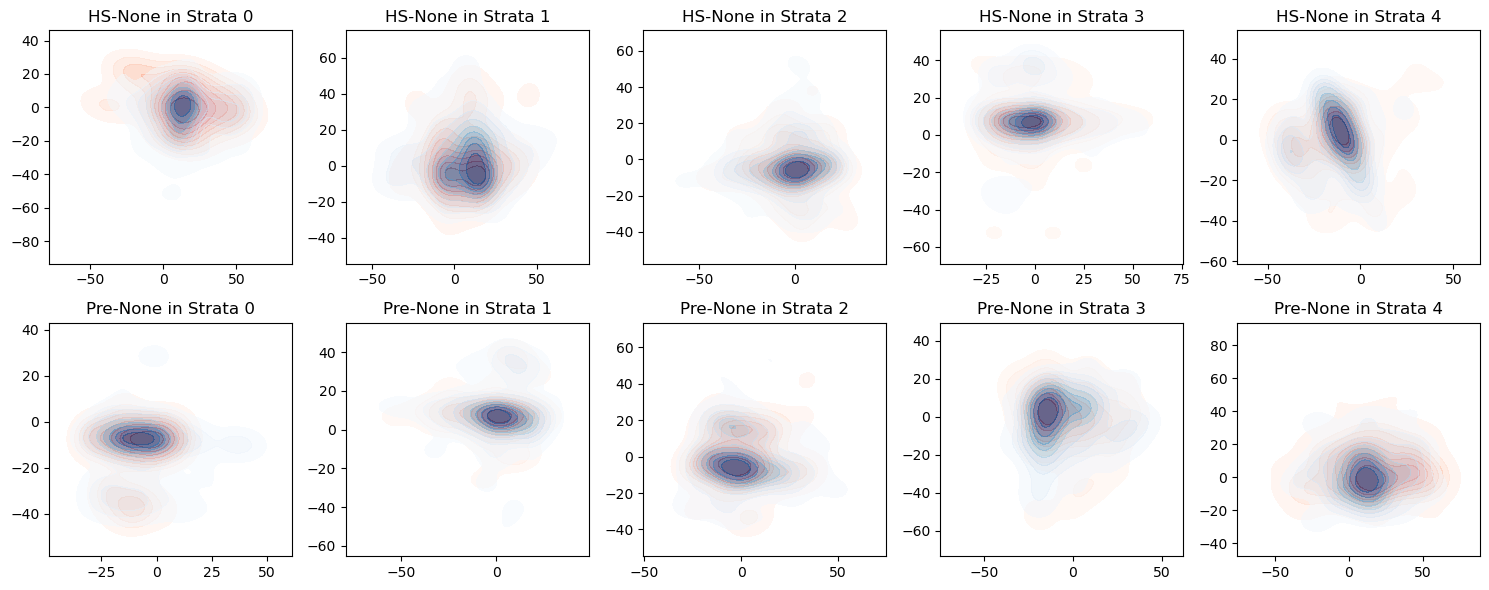

,Strata,"HStoNone, KS P-Value","HStoNone, Bonferroni KS P-Value","HStoNone, Mahalanobis Distance","HStoNone, MD P-Value","PretoNone, KS P-Value","PretoNone, Bonferroni KS P-Value","PretoNone, Mahalanobis Distance","PretoNone, MD P-Value"
0,0,1.0,0.167577,1.604962,1.0,1.0,1.0,1.19472,1.0
1,1,1.0,0.094765,1.326638,1.0,1.0,1.0,0.916484,1.0
2,2,1.0,1.0,0.913554,1.0,1.0,0.139591,0.93368,1.0
3,3,1.0,1.0,0.750579,1.0,1.0,1.0,0.813045,1.0
4,4,1.0,1.0,0.689738,1.0,1.0,1.0,0.936591,1.0


In [10]:
data = data_copy.copy()
data = preprocess(data)
data = impute(data)
data, covariates_centered = fit_propensity_score(data)

data["Male"] = data["male"]
data["HS"] = data["headstart_fixedeffect_indicator_90"]
data["Pre"] = data["preschool_fixedeffect_indicator_90"]

# Matched Score Check
def binary_search_alpha(X1, X2):
    low = 0.0
    high = 1.0
    for _ in range(10):
        alpha = (low + high) / 2
        rej = mkstest(X1, X2, alpha=alpha)
        if rej:
            high = alpha
        else:
            low = alpha
    return high
num_dim = len(covariates_centered)
assert num_dim == 55

num_strata = 5
strata_table = pd.DataFrame(columns=["Strata", 
                                     "HStoNone, KS P-Value", "HStoNone, Bonferroni KS P-Value", "HStoNone, Mahalanobis Distance", "HStoNone, MD P-Value", 
                                     "PretoNone, KS P-Value", "PretoNone, Bonferroni KS P-Value", "PretoNone, Mahalanobis Distance", "PretoNone, MD P-Value"], index=range(num_strata))
data["HS_Strata"] = pd.qcut(data["HS_pred_propensity_score"], num_strata, labels=False)
data["Pre_Strata"] = pd.qcut(data["Pre_pred_propensity_score"], num_strata, labels=False)

fig, axs = plt.subplots(2, num_strata, figsize=(3*num_strata, 6))
for strata in tqdm(range(num_strata)):
    strata_table.loc[strata, "Strata"] = strata
    for idx, g in enumerate(["HS", "Pre"]):
        mask = data[f"{g}_Strata"] == strata
        strata_data = data.loc[mask]
        covariate_treatment = strata_data.loc[strata_data[g] == 1, covariates_centered].to_numpy()
        covariate_control = strata_data.loc[strata_data[g] == 0, covariates_centered].to_numpy()
        p_value = binary_search_alpha(covariate_treatment, covariate_control)
        pooled_cov = (np.cov(covariate_treatment.T) * (len(covariate_treatment) - 1) + np.cov(covariate_control.T) * (len(covariate_control) - 1)) / (len(covariate_treatment) + len(covariate_control) - 2)
        md = mahalanobis(np.mean(covariate_treatment, axis=0), np.mean(covariate_control, axis=0), np.linalg.pinv(pooled_cov))
        strata_table.loc[strata, f"{g}toNone, KS P-Value"] = p_value
        strata_table.loc[strata, f"{g}toNone, Mahalanobis Distance"] = md
        dimensions = len(covariate_treatment[0])
        strata_table.loc[strata, f"{g}toNone, MD P-Value"] = 1 - chi2.cdf(md**2, dimensions)

        eigvals, eigvecs = np.linalg.eigh(pooled_cov)
        eigval_idx = eigvals.argsort()[::-1]
        covariate_treatment_projected = covariate_treatment @ eigvecs[:, eigval_idx[:2]]
        covariate_control_projected = covariate_control @ eigvecs[:, eigval_idx[:2]]
        sns.kdeplot(x=covariate_treatment_projected[:, 0], y=covariate_treatment_projected[:, 1], cmap="Reds", shade=True, label=f"{g} Treatment", alpha=0.5, ax=axs[idx, strata], legend=True)
        sns.kdeplot(x=covariate_control_projected[:, 0], y=covariate_control_projected[:, 1], cmap="Blues", shade=True, label=f"{g} Control", alpha=0.5, ax=axs[idx, strata], legend=True)
        axs[idx, strata].set_title(f"{g}-None in Strata {strata}")

        univariate_p_values = []
        for cov_name in covariates_centered:
            univariate_p_values.append(ks_2samp(strata_data.loc[strata_data[g] == 1, cov_name], strata_data.loc[strata_data[g] == 0, cov_name]).pvalue)
            # assert ks_2samp(strata_data.loc[strata_data[g] == 1, cov_name], strata_data.loc[strata_data[g] == 0, cov_name]).pvalue > 1 / num_dim,   # so bonferroni
        strata_table.loc[strata, f"{g}toNone, Bonferroni KS P-Value"] = np.minimum(np.min(univariate_p_values) * num_dim, 1)
        print(univariate_p_values)
plt.tight_layout()
plt.savefig("kde_covariates.png")
plt.show()

strata_table.to_csv("strata_table.csv")

del data["Male"]
del data["HS"]
del data["Pre"]

strata_table


In [5]:
# Table 4 robustness check
for elig_type in [1, 2]:
    data = data_copy.copy()
    data = preprocess(data, elig_type=elig_type)
    data = impute(data)
    data, covariates_centered = fit_propensity_score(data)
    data = postprocess(data)


    column_names = ["Test Scores, 5-6", "Test Scores, 7-10", "Test Scores, 11-14", "Test Scores, 5-14", 
                    "Nontest score, 5-14", "Long term, 19+"]
    row_names = ["Head Start, overall", "Head Start, overall, se", "Head Start, overall, p-value", 
                "Other preschool, overall", "Other preschool, overall, se", "Other preschool, overall, p-value", 
                "p (HS = preschool), overall"]
    table4 = pd.DataFrame(index=row_names, columns=column_names)

    baseline_covariates = ["HS_5to6", "HS_7to10", "HS_11to14", "Pre_5to6", "Pre_7to10", "Pre_11to14"]
    overall_baseline_covariates = ["headstart_fixedeffect_indicator_90", "preschool_fixedeffect_indicator_90"]
    standard_covariates = covariates_to_impute + [cov + "_missing" for cov in covariates_to_impute] + ["Male"]
    family_fixed_effects = ["C(AgeTest_Yr)", "C(Year)", "C(MotherID)"]

    # test scores
    mask = data['Test_std'].notna()
    model = smf.ols("Test_std ~ " + " + ".join(baseline_covariates + standard_covariates + family_fixed_effects), data=data.loc[mask]).fit(cov_type='cluster', cov_kwds={'groups': data.loc[mask, 'MotherID']})
    table4.loc["Head Start, overall", "Test Scores, 5-6"] = model.params["HS_5to6"]
    table4.loc["Head Start, overall, se", "Test Scores, 5-6"] = model.bse["HS_5to6"]
    table4.loc["Head Start, overall, p-value", "Test Scores, 5-6"] = model.t_test("HS_5to6 = 0").pvalue
    table4.loc["Head Start, overall", "Test Scores, 7-10"] = model.params["HS_7to10"]
    table4.loc["Head Start, overall, se", "Test Scores, 7-10"] = model.bse["HS_7to10"]
    table4.loc["Head Start, overall, p-value", "Test Scores, 7-10"] = model.t_test("HS_7to10 = 0").pvalue
    table4.loc["Head Start, overall", "Test Scores, 11-14"] = model.params["HS_11to14"]
    table4.loc["Head Start, overall, se", "Test Scores, 11-14"] = model.bse["HS_11to14"]
    table4.loc["Head Start, overall, p-value", "Test Scores, 11-14"] = model.t_test("HS_11to14 = 0").pvalue
    table4.loc["Other preschool, overall", "Test Scores, 5-6"] = model.params["Pre_5to6"]
    table4.loc["Other preschool, overall, se", "Test Scores, 5-6"] = model.bse["Pre_5to6"]
    table4.loc["Other preschool, overall, p-value", "Test Scores, 5-6"] = model.t_test("Pre_5to6 = 0").pvalue
    table4.loc["Other preschool, overall", "Test Scores, 7-10"] = model.params["Pre_7to10"]
    table4.loc["Other preschool, overall, se", "Test Scores, 7-10"] = model.bse["Pre_7to10"]
    table4.loc["Other preschool, overall, p-value", "Test Scores, 7-10"] = model.t_test("Pre_7to10 = 0").pvalue
    table4.loc["Other preschool, overall", "Test Scores, 11-14"] = model.params["Pre_11to14"]
    table4.loc["Other preschool, overall, se", "Test Scores, 11-14"] = model.bse["Pre_11to14"]
    table4.loc["Other preschool, overall, p-value", "Test Scores, 11-14"] = model.t_test("Pre_11to14 = 0").pvalue

    table4.loc["p (HS = preschool), overall", "Test Scores, 5-6"] = model.f_test("HS_5to6 = Pre_5to6").pvalue
    table4.loc["p (HS = preschool), overall", "Test Scores, 7-10"] = model.f_test("HS_7to10 = Pre_7to10").pvalue
    table4.loc["p (HS = preschool), overall", "Test Scores, 11-14"] = model.f_test("HS_11to14 = Pre_11to14").pvalue


    model = smf.ols("Test_std ~ " + " + ".join(overall_baseline_covariates + standard_covariates + family_fixed_effects), data=data.loc[mask]).fit(cov_type='cluster', cov_kwds={'groups': data.loc[mask, 'MotherID']})
    table4.loc["Head Start, overall", "Test Scores, 5-14"] = model.params["headstart_fixedeffect_indicator_90"]
    table4.loc["Head Start, overall, se", "Test Scores, 5-14"] = model.bse["headstart_fixedeffect_indicator_90"]
    table4.loc["Head Start, overall, p-value", "Test Scores, 5-14"] = model.t_test("headstart_fixedeffect_indicator_90 = 0").pvalue
    table4.loc["Other preschool, overall", "Test Scores, 5-14"] = model.params["preschool_fixedeffect_indicator_90"]
    table4.loc["Other preschool, overall, se", "Test Scores, 5-14"] = model.bse["preschool_fixedeffect_indicator_90"]
    table4.loc["Other preschool, overall, p-value", "Test Scores, 5-14"] = model.t_test("preschool_fixedeffect_indicator_90 = 0").pvalue

    table4.loc["p (HS = preschool), overall", "Test Scores, 5-14"] = model.f_test("headstart_fixedeffect_indicator_90 = preschool_fixedeffect_indicator_90").pvalue


    # noncognitive outcomes, 5-14
    mask = data['Noncog'].notna()
    model = smf.ols("Noncog ~ " + " + ".join(overall_baseline_covariates + standard_covariates + family_fixed_effects), data=data.loc[mask]).fit(cov_type='cluster', cov_kwds={'groups': data.loc[mask, 'MotherID']})
    table4.loc["Head Start, overall", "Nontest score, 5-14"] = model.params["headstart_fixedeffect_indicator_90"]
    table4.loc["Head Start, overall, se", "Nontest score, 5-14"] = model.bse["headstart_fixedeffect_indicator_90"]
    table4.loc["Head Start, overall, p-value", "Nontest score, 5-14"] = model.t_test("headstart_fixedeffect_indicator_90 = 0").pvalue
    table4.loc["Other preschool, overall", "Nontest score, 5-14"] = model.params["preschool_fixedeffect_indicator_90"]
    table4.loc["Other preschool, overall, se", "Nontest score, 5-14"] = model.bse["preschool_fixedeffect_indicator_90"]
    table4.loc["Other preschool, overall, p-value", "Nontest score, 5-14"] = model.t_test("preschool_fixedeffect_indicator_90 = 0").pvalue

    table4.loc["p (HS = preschool), overall", "Nontest score, 5-14"] = model.f_test("headstart_fixedeffect_indicator_90 = preschool_fixedeffect_indicator_90").pvalue


    # long term outcomes
    mask = data['Sum_Adult'].notna()
    model = smf.ols("Sum_Adult ~ " + " + ".join(overall_baseline_covariates + standard_covariates + family_fixed_effects), data=data.loc[mask]).fit(cov_type='cluster', cov_kwds={'groups': data.loc[mask, 'MotherID']})
    table4.loc["Head Start, overall", "Long term, 19+"] = model.params["headstart_fixedeffect_indicator_90"]
    table4.loc["Head Start, overall, se", "Long term, 19+"] = model.bse["headstart_fixedeffect_indicator_90"]
    table4.loc["Head Start, overall, p-value", "Long term, 19+"] = model.t_test("headstart_fixedeffect_indicator_90 = 0").pvalue
    table4.loc["Other preschool, overall", "Long term, 19+"] = model.params["preschool_fixedeffect_indicator_90"]
    table4.loc["Other preschool, overall, se", "Long term, 19+"] = model.bse["preschool_fixedeffect_indicator_90"]
    table4.loc["Other preschool, overall, p-value", "Long term, 19+"] = model.t_test("preschool_fixedeffect_indicator_90 = 0").pvalue

    table4.loc["p (HS = preschool), overall", "Long term, 19+"] = model.f_test("headstart_fixedeffect_indicator_90 = preschool_fixedeffect_indicator_90").pvalue
    table4.to_csv(f"table4_panel_a_eligtype{elig_type}.csv")

1432
1455


In [6]:
# Table 4 with interaction
data = data_copy.copy()
data = preprocess(data)
data = impute(data)
data, covariates_centered = fit_propensity_score(data)
data = postprocess(data)


column_names = ["Test Scores, 5-6", "Test Scores, 7-10", "Test Scores, 11-14", "Test Scores, 5-14", 
                "Nontest score, 5-14", "Long term, 19+"]
row_names = ["Head Start, overall", "Head Start, overall, se", "Head Start, overall, p-value", 
             "Other preschool, overall", "Other preschool, overall, se", "Other preschool, overall, p-value", 
             "p (HS = preschool), overall"]
table4 = pd.DataFrame(index=row_names, columns=column_names)

baseline_covariates = ["HS_5to6", "HS_7to10", "HS_11to14", "Pre_5to6", "Pre_7to10", "Pre_11to14"]
overall_baseline_covariates = ["headstart_fixedeffect_indicator_90", "preschool_fixedeffect_indicator_90"]
# add interaction terms
for cov in covariates_centered:
    data[cov + "_x_HS"] = data[cov] * data["headstart_fixedeffect_indicator_90"]
    data[cov + "_x_Pre"] = data[cov] * data["preschool_fixedeffect_indicator_90"]
covariates_interaction = [cov + "_x_HS" for cov in covariates_centered] + [cov + "_x_Pre" for cov in covariates_centered]
# this is the covariates now
standard_covariates = covariates_centered + covariates_interaction
family_fixed_effects = ["C(MotherID)", "C(AgeTest_Yr)", "C(Year)"]

# test scores
mask = data['Test_std'].notna()
model = smf.ols("Test_std ~ " + " + ".join(baseline_covariates + standard_covariates + family_fixed_effects), data=data.loc[mask]).fit(cov_type='cluster', cov_kwds={'groups': data.loc[mask, 'MotherID']})
table4.loc["Head Start, overall", "Test Scores, 5-6"] = model.params["HS_5to6"]
table4.loc["Head Start, overall, se", "Test Scores, 5-6"] = model.bse["HS_5to6"]
table4.loc["Head Start, overall, p-value", "Test Scores, 5-6"] = model.t_test("HS_5to6 = 0").pvalue
table4.loc["Head Start, overall", "Test Scores, 7-10"] = model.params["HS_7to10"]
table4.loc["Head Start, overall, se", "Test Scores, 7-10"] = model.bse["HS_7to10"]
table4.loc["Head Start, overall, p-value", "Test Scores, 7-10"] = model.t_test("HS_7to10 = 0").pvalue
table4.loc["Head Start, overall", "Test Scores, 11-14"] = model.params["HS_11to14"]
table4.loc["Head Start, overall, se", "Test Scores, 11-14"] = model.bse["HS_11to14"]
table4.loc["Head Start, overall, p-value", "Test Scores, 11-14"] = model.t_test("HS_11to14 = 0").pvalue
table4.loc["Other preschool, overall", "Test Scores, 5-6"] = model.params["Pre_5to6"]
table4.loc["Other preschool, overall, se", "Test Scores, 5-6"] = model.bse["Pre_5to6"]
table4.loc["Other preschool, overall, p-value", "Test Scores, 5-6"] = model.t_test("Pre_5to6 = 0").pvalue
table4.loc["Other preschool, overall", "Test Scores, 7-10"] = model.params["Pre_7to10"]
table4.loc["Other preschool, overall, se", "Test Scores, 7-10"] = model.bse["Pre_7to10"]
table4.loc["Other preschool, overall, p-value", "Test Scores, 7-10"] = model.t_test("Pre_7to10 = 0").pvalue
table4.loc["Other preschool, overall", "Test Scores, 11-14"] = model.params["Pre_11to14"]
table4.loc["Other preschool, overall, se", "Test Scores, 11-14"] = model.bse["Pre_11to14"]
table4.loc["Other preschool, overall, p-value", "Test Scores, 11-14"] = model.t_test("Pre_11to14 = 0").pvalue

table4.loc["p (HS = preschool), overall", "Test Scores, 5-6"] = model.f_test("HS_5to6 = Pre_5to6").pvalue
table4.loc["p (HS = preschool), overall", "Test Scores, 7-10"] = model.f_test("HS_7to10 = Pre_7to10").pvalue
table4.loc["p (HS = preschool), overall", "Test Scores, 11-14"] = model.f_test("HS_11to14 = Pre_11to14").pvalue


model = smf.ols("Test_std ~ " + " + ".join(overall_baseline_covariates + standard_covariates + family_fixed_effects), data=data.loc[mask]).fit(cov_type='cluster', cov_kwds={'groups': data.loc[mask, 'MotherID']})
table4.loc["Head Start, overall", "Test Scores, 5-14"] = model.params["headstart_fixedeffect_indicator_90"]
table4.loc["Head Start, overall, se", "Test Scores, 5-14"] = model.bse["headstart_fixedeffect_indicator_90"]
table4.loc["Head Start, overall, p-value", "Test Scores, 5-14"] = model.t_test("headstart_fixedeffect_indicator_90 = 0").pvalue
table4.loc["Other preschool, overall", "Test Scores, 5-14"] = model.params["preschool_fixedeffect_indicator_90"]
table4.loc["Other preschool, overall, se", "Test Scores, 5-14"] = model.bse["preschool_fixedeffect_indicator_90"]
table4.loc["Other preschool, overall, p-value", "Test Scores, 5-14"] = model.t_test("preschool_fixedeffect_indicator_90 = 0").pvalue

table4.loc["p (HS = preschool), overall", "Test Scores, 5-14"] = model.f_test("headstart_fixedeffect_indicator_90 = preschool_fixedeffect_indicator_90").pvalue


# noncognitive outcomes, 5-14
mask = data['Noncog'].notna()
model = smf.ols("Noncog ~ " + " + ".join(overall_baseline_covariates + standard_covariates + family_fixed_effects), data=data.loc[mask]).fit(cov_type='cluster', cov_kwds={'groups': data.loc[mask, 'MotherID']})
table4.loc["Head Start, overall", "Nontest score, 5-14"] = model.params["headstart_fixedeffect_indicator_90"]
table4.loc["Head Start, overall, se", "Nontest score, 5-14"] = model.bse["headstart_fixedeffect_indicator_90"]
table4.loc["Head Start, overall, p-value", "Nontest score, 5-14"] = model.t_test("headstart_fixedeffect_indicator_90 = 0").pvalue
table4.loc["Other preschool, overall", "Nontest score, 5-14"] = model.params["preschool_fixedeffect_indicator_90"]
table4.loc["Other preschool, overall, se", "Nontest score, 5-14"] = model.bse["preschool_fixedeffect_indicator_90"]
table4.loc["Other preschool, overall, p-value", "Nontest score, 5-14"] = model.t_test("preschool_fixedeffect_indicator_90 = 0").pvalue

table4.loc["p (HS = preschool), overall", "Nontest score, 5-14"] = model.f_test("headstart_fixedeffect_indicator_90 = preschool_fixedeffect_indicator_90").pvalue


# long term outcomes
mask = data['Sum_Adult'].notna()
model = smf.ols("Sum_Adult ~ " + " + ".join(overall_baseline_covariates + standard_covariates + family_fixed_effects), data=data.loc[mask]).fit(cov_type='cluster', cov_kwds={'groups': data.loc[mask, 'MotherID']})
table4.loc["Head Start, overall", "Long term, 19+"] = model.params["headstart_fixedeffect_indicator_90"]
table4.loc["Head Start, overall, se", "Long term, 19+"] = model.bse["headstart_fixedeffect_indicator_90"]
table4.loc["Head Start, overall, p-value", "Long term, 19+"] = model.t_test("headstart_fixedeffect_indicator_90 = 0").pvalue
table4.loc["Other preschool, overall", "Long term, 19+"] = model.params["preschool_fixedeffect_indicator_90"]
table4.loc["Other preschool, overall, se", "Long term, 19+"] = model.bse["preschool_fixedeffect_indicator_90"]
table4.loc["Other preschool, overall, p-value", "Long term, 19+"] = model.t_test("preschool_fixedeffect_indicator_90 = 0").pvalue

table4.loc["p (HS = preschool), overall", "Long term, 19+"] = model.f_test("headstart_fixedeffect_indicator_90 = preschool_fixedeffect_indicator_90").pvalue
table4.to_csv("table4_panel_a_olswithinteraction.csv")
table4


1455


,"Test Scores, 5-6","Test Scores, 7-10","Test Scores, 11-14","Test Scores, 5-14","Nontest score, 5-14","Long term, 19+"
"Head Start, overall",0.147193,0.145941,0.073147,0.114094,0.196415,0.276157
"Head Start, overall, se",0.097111,0.070375,0.072565,0.068325,0.105624,0.088489
"Head Start, overall, p-value",0.12958964216941915,0.03810161980827757,0.3134465799178343,0.09494742243713064,0.06294787701698505,0.0018035706304030306
"Other preschool, overall",0.010843,0.083869,0.014437,0.042288,0.084525,0.050241
"Other preschool, overall, se",0.091735,0.071268,0.073385,0.067789,0.098145,0.080467
"Other preschool, overall, p-value",0.9059133217391765,0.23927308514489043,0.8440428548307526,0.5327468560791206,0.3891125926497485,0.5323888805893658
"p (HS = preschool), overall",0.206982,0.479311,0.499426,0.39606,0.380361,0.031147


In [7]:
def hajek(data, group_name, hs_name, pre_name, outcome_name):
    mask = (data[group_name] == 1) & (data[outcome_name].notna())
    data_group = data.loc[mask].copy()
    data_group["None_tmp"] = ((data_group[hs_name] == 0) & (data_group[pre_name] == 0)).astype(int)

    tau_hs = (data_group[outcome_name] * data_group[hs_name] / data_group["HS_pred_propensity_score"]).sum() / (data_group[hs_name] / data_group["HS_pred_propensity_score"]).sum() -\
                (data_group[outcome_name] * data_group["None_tmp"] / (1 - data_group["HS_pred_propensity_score"])).sum() / (data_group["None_tmp"] / (1 - data_group["HS_pred_propensity_score"])).sum()
    tau_pre = (data_group[outcome_name] * data_group[pre_name] / data_group["Pre_pred_propensity_score"]).sum() / (data_group[pre_name] / data_group["Pre_pred_propensity_score"]).sum() -\
                (data_group[outcome_name] * data_group["None_tmp"] / (1 - data_group["Pre_pred_propensity_score"])).sum() / (data_group["None_tmp"] / (1 - data_group["Pre_pred_propensity_score"])).sum()
    return tau_hs, tau_pre

def hajek_and_bootstrap(data_imputed, group_name, hs_name, pre_name, outcome_name, num_iter=1000):
    data_imputed = data_imputed.copy()
    data, _ = fit_propensity_score(data_imputed)
    data = postprocess(data_imputed)
    tau_hs, tau_pre = hajek(data, group_name, hs_name, pre_name, outcome_name)
    tau_hs_boot = []
    tau_pre_boot = []
    for _ in tqdm(range(num_iter)):
        boot_data_imputed = data_imputed.sample(frac=1, replace=True)
        boot_data, _ = fit_propensity_score(boot_data_imputed)
        boot_data["ChildID"] = np.arange(len(boot_data))
        boot_data = postprocess(boot_data)
        tau_hs_b, tau_pre_b = hajek(boot_data, group_name, hs_name, pre_name, outcome_name)
        tau_hs_boot.append(tau_hs_b)
        tau_pre_boot.append(tau_pre_b)
    tau_hs_se, tau_pre_se = np.std(tau_hs_boot), np.std(tau_pre_boot)

    tau_hs_boot = np.array(tau_hs_boot)
    tau_pre_boot = np.array(tau_pre_boot)
    tau_diff = tau_hs_boot - tau_pre_boot
    tau_hs_boot = tau_hs_boot - tau_hs_boot.mean()
    tau_pre_boot = tau_pre_boot - tau_pre_boot.mean()
    tau_diff = tau_diff - tau_diff.mean()
    tau_hs_pvalue = np.mean(tau_hs_boot >= tau_hs)
    tau_pre_pvalue = np.mean(tau_pre_boot >= tau_pre)
    pvalue_sameeffect = np.mean(np.abs(tau_diff) >= np.abs(tau_hs - tau_pre))

    return tau_hs, tau_hs_se, tau_hs_pvalue, tau_pre, tau_pre_se, tau_pre_pvalue, pvalue_sameeffect


column_names = ["Test Scores, 5-6", "Test Scores, 7-10", "Test Scores, 11-14", "Test Scores, 5-14", 
                "Nontest score, 5-14", "Long term, 19+"]
row_names = ["Head Start, overall", "Head Start, overall, se", "Head Start, overall, p-value", 
             "Other preschool, overall", "Other preschool, overall, se", "Other preschool, overall, p-value", 
             "p (HS = preschool), overall"]
table4 = pd.DataFrame(index=row_names, columns=column_names)

# test scores
data = data_copy.copy()
data = preprocess(data)
data_imputed = impute(data)
data_imputed["HS_5to14"] = data_imputed["headstart_fixedeffect_indicator_90"]
data_imputed["Pre_5to14"] = data_imputed["preschool_fixedeffect_indicator_90"]
for group in ["5to6", "7to10", "11to14", "5to14"]:
    tau_hs, tau_hs_se, tau_hs_pvalue, tau_pre, tau_pre_se, tau_pre_pvalue, pvalue_sameeffect = hajek_and_bootstrap(data_imputed, f"Group_{group}", f"HS_{group}", f"Pre_{group}", "Test_std")
    table4.loc["Head Start, overall", f"Test Scores, {group.replace("to", "-")}"] = tau_hs
    table4.loc["Head Start, overall, se", f"Test Scores, {group.replace("to", "-")}"] = tau_hs_se
    table4.loc["Head Start, overall, p-value", f"Test Scores, {group.replace("to", "-")}"] = tau_hs_pvalue
    table4.loc["Other preschool, overall", f"Test Scores, {group.replace("to", "-")}"] = tau_pre
    table4.loc["Other preschool, overall, se", f"Test Scores, {group.replace("to", "-")}"] = tau_pre_se
    table4.loc["Other preschool, overall, p-value", f"Test Scores, {group.replace("to", "-")}"] = tau_pre_pvalue
    table4.loc["p (HS = preschool), overall", f"Test Scores, {group.replace("to", "-")}"] = pvalue_sameeffect

# noncognitive outcomes, 5-14
tau_hs, tau_hs_se, tau_hs_pvalue, tau_pre, tau_pre_se, tau_pre_pvalue, pvalue_sameeffect = hajek_and_bootstrap(data_imputed, "Group_5to14", "HS_5to14", "Pre_5to14", "Noncog")
table4.loc["Head Start, overall", "Nontest score, 5-14"] = tau_hs
table4.loc["Head Start, overall, se", "Nontest score, 5-14"] = tau_hs_se
table4.loc["Head Start, overall, p-value", "Nontest score, 5-14"] = tau_hs_pvalue
table4.loc["Other preschool, overall", "Nontest score, 5-14"] = tau_pre
table4.loc["Other preschool, overall, se", "Nontest score, 5-14"] = tau_pre_se
table4.loc["Other preschool, overall, p-value", "Nontest score, 5-14"] = tau_pre_pvalue
table4.loc["p (HS = preschool), overall", "Nontest score, 5-14"] = pvalue_sameeffect

# long term outcomes
tau_hs, tau_hs_se, tau_hs_pvalue, tau_pre, tau_pre_se, tau_pre_pvalue, pvalue_sameeffect = hajek_and_bootstrap(data_imputed, "Group_5to14", "HS_5to14", "Pre_5to14", "Sum_Adult")
table4.loc["Head Start, overall", "Long term, 19+"] = tau_hs
table4.loc["Head Start, overall, se", "Long term, 19+"] = tau_hs_se
table4.loc["Head Start, overall, p-value", "Long term, 19+"] = tau_hs_pvalue
table4.loc["Other preschool, overall", "Long term, 19+"] = tau_pre
table4.loc["Other preschool, overall, se", "Long term, 19+"] = tau_pre_se
table4.loc["Other preschool, overall, p-value", "Long term, 19+"] = tau_pre_pvalue
table4.loc["p (HS = preschool), overall", "Long term, 19+"] = pvalue_sameeffect

table4.to_csv("table4_panel_a_hajek.csv")
table4

1455


100%|██████████| 1000/1000 [06:08<00:00,  2.71it/s]


,"Test Scores, 5-6","Test Scores, 7-10","Test Scores, 11-14","Test Scores, 5-14","Nontest score, 5-14","Long term, 19+"
"Head Start, overall",0.127007,0.046983,-0.046083,0.021417,0.077909,0.121551
"Head Start, overall, se",0.082628,0.068346,0.06709,0.058873,0.075556,0.078426
"Head Start, overall, p-value",0.053,0.237,0.753,0.349,0.151,0.059
"Other preschool, overall",0.024709,-0.009875,-0.073832,-0.030342,0.014098,0.075427
"Other preschool, overall, se",0.092143,0.06831,0.076297,0.061849,0.07094,0.07153
"Other preschool, overall, p-value",0.386,0.569,0.835,0.681,0.414,0.146
"p (HS = preschool), overall",0.299,0.46,0.745,0.447,0.438,0.58


In [9]:
standard_covariates = covariates_to_impute + [cov + "_missing" for cov in covariates_to_impute]
family_fixed_effects = ["C(MotherID)", "C(AgeTest_Yr)", "C(Year)"]

def doubly_robust(data, group_name, hs_name, pre_name, outcome_name):
    mask = (data[group_name] == 1) & (data[outcome_name].notna())
    data_group = data.loc[mask].copy()
    data_group["None_tmp"] = ((data_group[hs_name] == 0) & (data_group[pre_name] == 0)).astype(int)
    if group_name == "Group_5to14":
        model = smf.ols(f"{outcome_name} ~ " + " + ".join([hs_name, pre_name] + standard_covariates + family_fixed_effects), data=data.loc[mask]).fit(cov_type='cluster', cov_kwds={'groups': data.loc[mask, 'MotherID']})
    else:
        model = smf.ols(f"{outcome_name} ~ " + " + ".join([hs_name, pre_name] + standard_covariates + family_fixed_effects), data=data.loc[mask]).fit(cov_type='cluster', cov_kwds={'groups': data.loc[mask, 'MotherID']})
    hs_effect = model.params[hs_name]
    pre_effect = model.params[pre_name]

    data_group_hs = data_group.copy()
    data_group_hs[hs_name] = 1
    data_group["mu1_hs"] = model.predict(data_group_hs)
    data_group["mu0_hs"] = data_group["mu1_hs"] - hs_effect
    data_group["mu1_pre"] = model.predict(data_group_hs)
    data_group_pre = data_group.copy()
    data_group_pre[pre_name] = 1
    data_group["mu1_pre"] = model.predict(data_group_pre)
    data_group["mu0_pre"] = data_group["mu1_pre"] - pre_effect
    # HS vs None
    mask_hs_none = (data_group[hs_name] == 1) | (data_group["None_tmp"] == 1)
    data_group_hs_none = data_group.loc[mask_hs_none]
    mu1_HS_dr = (data_group_hs_none[hs_name] * (data_group_hs_none[outcome_name] - data_group_hs_none["mu1_hs"]) / data_group_hs_none["HS_pred_propensity_score"] + data_group_hs_none["mu1_hs"]).mean()
    mu0_HS_dr = (data_group_hs_none["None_tmp"] * (data_group_hs_none[outcome_name] - data_group_hs_none["mu0_hs"]) / (1 - data_group_hs_none["HS_pred_propensity_score"]) + data_group_hs_none["mu0_hs"]).mean() 
    tau_hs = mu1_HS_dr - mu0_HS_dr
    # Pre vs None
    mask_pre_none = (data_group[pre_name] == 1) | (data_group["None_tmp"] == 1)
    data_group_pre_none = data_group.loc[mask_pre_none]
    mu1_Pre_dr = (data_group_pre_none[pre_name] * (data_group_pre_none[outcome_name] - data_group_pre_none["mu1_pre"]) / data_group_pre_none["Pre_pred_propensity_score"] + data_group_pre_none["mu1_pre"]).mean()
    mu0_Pre_dr = (data_group_pre_none["None_tmp"] * (data_group_pre_none[outcome_name] - data_group_pre_none["mu0_pre"]) / (1 - data_group_pre_none["Pre_pred_propensity_score"]) + data_group_pre_none["mu0_pre"]).mean()
    tau_pre = mu1_Pre_dr - mu0_Pre_dr
    return tau_hs, tau_pre

def doubly_robust_and_bootstrap(data_imputed, group_name, hs_name, pre_name, outcome_name, num_iter=1000):
    data_imputed = data_imputed.copy()
    data, _ = fit_propensity_score(data_imputed)
    data = postprocess(data_imputed)
    tau_hs, tau_pre = doubly_robust(data, group_name, hs_name, pre_name, outcome_name)
    tau_hs_boot = []
    tau_pre_boot = []
    for _ in tqdm(range(num_iter)):
        tau_hs_b, tau_pre_b = None, None
        while tau_hs_b is None:
            try:
                boot_data_imputed = data_imputed.sample(frac=1, replace=True)
                boot_data, _ = fit_propensity_score(boot_data_imputed)
                boot_data["ChildID"] = np.arange(len(boot_data))
                boot_data = postprocess(boot_data)
                tau_hs_b, tau_pre_b = doubly_robust(boot_data, group_name, hs_name, pre_name, outcome_name)
            except Exception as e:
                continue
        tau_hs_boot.append(tau_hs_b)
        tau_pre_boot.append(tau_pre_b)
    tau_hs_se, tau_pre_se = np.std(tau_hs_boot), np.std(tau_pre_boot)

    tau_hs_boot = np.array(tau_hs_boot)
    tau_pre_boot = np.array(tau_pre_boot)
    tau_diff = tau_hs_boot - tau_pre_boot
    tau_hs_boot = tau_hs_boot - tau_hs_boot.mean()
    tau_pre_boot = tau_pre_boot - tau_pre_boot.mean()
    tau_diff = tau_diff - tau_diff.mean()
    tau_hs_pvalue = np.mean(tau_hs_boot >= tau_hs)
    tau_pre_pvalue = np.mean(tau_pre_boot >= tau_pre)
    pvalue_sameeffect = np.mean(np.abs(tau_diff) >= np.abs(tau_hs - tau_pre))

    return tau_hs, tau_hs_se, tau_hs_pvalue, tau_pre, tau_pre_se, tau_pre_pvalue, pvalue_sameeffect


column_names = ["Test Scores, 5-6", "Test Scores, 7-10", "Test Scores, 11-14", "Test Scores, 5-14", 
                "Nontest score, 5-14", "Long term, 19+"]
row_names = ["Head Start, overall", "Head Start, overall, se", "Head Start, overall, p-value", 
             "Other preschool, overall", "Other preschool, overall, se", "Other preschool, overall, p-value", 
             "p (HS = preschool), overall"]
table4 = pd.DataFrame(index=row_names, columns=column_names)

# test scores
data = data_copy.copy()
data = preprocess(data)
data_imputed = impute(data)
data_imputed["HS_5to14"] = data_imputed["headstart_fixedeffect_indicator_90"]
data_imputed["Pre_5to14"] = data_imputed["preschool_fixedeffect_indicator_90"]
for group in ["5to6", "7to10", "11to14", "5to14"]:
    tau_hs, tau_hs_se, tau_hs_pvalue, tau_pre, tau_pre_se, tau_pre_pvalue, pvalue_sameeffect = doubly_robust_and_bootstrap(data_imputed, f"Group_{group}", f"HS_{group}", f"Pre_{group}", "Test_std")
    table4.loc["Head Start, overall", f"Test Scores, {group.replace("to", "-")}"] = tau_hs
    table4.loc["Head Start, overall, se", f"Test Scores, {group.replace("to", "-")}"] = tau_hs_se
    table4.loc["Head Start, overall, p-value", f"Test Scores, {group.replace("to", "-")}"] = tau_hs_pvalue
    table4.loc["Other preschool, overall", f"Test Scores, {group.replace("to", "-")}"] = tau_pre
    table4.loc["Other preschool, overall, se", f"Test Scores, {group.replace("to", "-")}"] = tau_pre_se
    table4.loc["Other preschool, overall, p-value", f"Test Scores, {group.replace("to", "-")}"] = tau_pre_pvalue
    table4.loc["p (HS = preschool), overall", f"Test Scores, {group.replace("to", "-")}"] = pvalue_sameeffect

# noncognitive outcomes, 5-14
tau_hs, tau_hs_se, tau_hs_pvalue, tau_pre, tau_pre_se, tau_pre_pvalue, pvalue_sameeffect = doubly_robust_and_bootstrap(data_imputed, "Group_5to14", "HS_5to14", "Pre_5to14", "Noncog")
table4.loc["Head Start, overall", "Nontest score, 5-14"] = tau_hs
table4.loc["Head Start, overall, se", "Nontest score, 5-14"] = tau_hs_se
table4.loc["Head Start, overall, p-value", "Nontest score, 5-14"] = tau_hs_pvalue
table4.loc["Other preschool, overall", "Nontest score, 5-14"] = tau_pre
table4.loc["Other preschool, overall, se", "Nontest score, 5-14"] = tau_pre_se
table4.loc["Other preschool, overall, p-value", "Nontest score, 5-14"] = tau_pre_pvalue
table4.loc["p (HS = preschool), overall", "Nontest score, 5-14"] = pvalue_sameeffect

# long term outcomes
tau_hs, tau_hs_se, tau_hs_pvalue, tau_pre, tau_pre_se, tau_pre_pvalue, pvalue_sameeffect = doubly_robust_and_bootstrap(data_imputed, "Group_5to14", "HS_5to14", "Pre_5to14", "Sum_Adult")
table4.loc["Head Start, overall", "Long term, 19+"] = tau_hs
table4.loc["Head Start, overall, se", "Long term, 19+"] = tau_hs_se
table4.loc["Head Start, overall, p-value", "Long term, 19+"] = tau_hs_pvalue
table4.loc["Other preschool, overall", "Long term, 19+"] = tau_pre
table4.loc["Other preschool, overall, se", "Long term, 19+"] = tau_pre_se
table4.loc["Other preschool, overall, p-value", "Long term, 19+"] = tau_pre_pvalue
table4.loc["p (HS = preschool), overall", "Long term, 19+"] = pvalue_sameeffect
table4.to_csv("table4_panel_a_doubly_robust.csv")
table4

1455


100%|██████████| 1000/1000 [15:12<00:00,  1.10it/s]


,"Test Scores, 5-6","Test Scores, 7-10","Test Scores, 11-14","Test Scores, 5-14","Nontest score, 5-14","Long term, 19+"
"Head Start, overall",0.306595,0.140523,0.072444,0.109072,0.251578,0.26259
"Head Start, overall, se",0.184999,0.09322,0.094151,0.07807,0.119691,0.106315
"Head Start, overall, p-value",0.038,0.06,0.221,0.085,0.02,0.005
"Other preschool, overall",-0.020079,0.006308,0.018605,0.005385,0.089457,0.064264
"Other preschool, overall, se",0.167455,0.092775,0.093065,0.077027,0.119511,0.09435
"Other preschool, overall, p-value",0.538,0.479,0.419,0.483,0.225,0.239
"p (HS = preschool), overall",0.109,0.193,0.628,0.262,0.277,0.122
